# Table of contents
1. [Load Data](#loaddata)  
2. [Data Pre-processing](#datapreprocessing)
3. [Preliminary EDA](#eda1)
4. [Categorical Encoding](#catenc)
5. [EDA on Basic Features](#eda2)
6. [Feature Engineering](#fe)
7. [Undersampling](#undersampling)
8. [EDA on Newly Created Features](#eda3)
9. [Load Undersampled Train](#train)
10. [Feature Selection](#featureselection)
12. [Preparing Testing Set](#preptest)
13. [Model Building](#modelbuilding)  
  13.1 [Logistic Regression](#lr)  
  13.2 [K Nearest Neighbours (KNN)](#knn)  
  13.3 [Neural Network](#nnbo)  
  13.4 [Random Forest](#rf)  
  13.5 [XGBoost](#xg)      
14. [Archive](#archive)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# For statistical tests
from scipy import stats

from xgboost import XGBClassifier, plot_importance
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix

In [48]:
# For loading dataset which exceeds memory
import dask.dataframe as dd

# For categorical encoding
import category_encoders as ce

# For normalization
from sklearn.preprocessing import MinMaxScaler

# For combination
from itertools import combinations

# To ignore warning
import warnings
warnings.filterwarnings("ignore")

# For evaluation metrics
from sklearn import metrics

## Load Data <a name="loaddata"></a>

In [3]:
data = dd.read_csv('./data.csv', dtype={'attributed_time': 'object'})

#### Summary of Variables

| Variable Name   | Definition                                                                | Type        |
|-----------------|---------------------------------------------------------------------------|-------------|
| ip              | IP address of click                                                       | Categorical |
| app             | App id for marketing                                                      | Categorical |
| device          | Device type id of mobile phone                                            | Categorical |
| os              | OS version id of mobile phone                                             | Categorical |
| channel         | Channel id of ad publisher                                                | Categorical |
| click_time      | Timestamp of click (UTC)                                                  | Numerical   |
| attributed_time | If user downloads app after clicking ad, this is the time of app download | Numerical   |
| is_attributed   | Target to be predicted, 1 if app was downloaded                           | Categorical |

As attributed_time is only available when the app was downloaded (is_attributed = 1), this variable will not provide much useful information about whether certain users will download the app or not. Therefore, we decided to **drop attributed_time** to free up more memory.

In [9]:
print(f"Number of observations: {data.shape[0].compute()}")

Number of observations: 184903890


Besides, we observe that this dataset is huge with more than 184 million observations, which cannot be handled by our machines. Hence we decided to **randomly take approximately 25% of the observations as samples** from the original dataset to reduce its size. We believe that after random sampling, the data size is still big enough for us to do analysis.

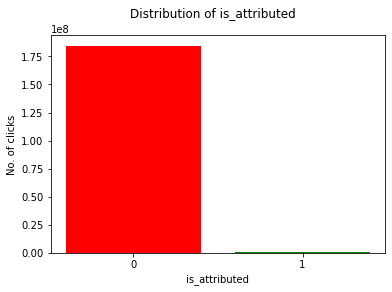

In [16]:
# Obtain counts of each class
data_0, data_1 = data["is_attributed"].value_counts()

# Plot distribution of is_attributed
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']
counts= [data_0, data_1]
ax.set_ylabel('No. of clicks')
ax.set_xlabel("is_attributed")
bars = ax.bar(labels, counts, color = ('red','green'))
plt.show()

From the plot above, we also observe that the dataset is highly imbalanced. Therefore, in the later part of the project, we will perform **undersampling on the training set**.

## Data Pre-processing <a name="datapreprocessing"></a>

### Random Sampling (without replacement)

In [2]:
<a name="introduction"></a># Read data by chunks of 10 million observations
# Sample 2.5 million observations randomly without replacement

data = pd.DataFrame()

chunksize = 10**7
with pd.read_csv('./data.csv', chunksize=chunksize) as reader:
  for chunk in reader:
    chunk = chunk.sample(n = int(chunksize/4), replace = False, random_state = 0)
    data = pd.concat([data, chunk])
    print(data.shape)

(2500000, 8)
(5000000, 8)
(7500000, 8)
(10000000, 8)
(12500000, 8)
(15000000, 8)
(17500000, 8)
(20000000, 8)
(22500000, 8)
(25000000, 8)
(27500000, 8)
(30000000, 8)
(32500000, 8)
(35000000, 8)
(37500000, 8)
(40000000, 8)
(42500000, 8)
(45000000, 8)
(47500000, 8)


In [28]:
print(data.shape)
print(data["is_attributed"].value_counts())

(47500000, 8)
0    47383465
1      116535
Name: is_attributed, dtype: int64


### Remove Duplicates

In [3]:
print('Check whether there are duplicates:', data.duplicated().any())
print('Number of duplicates:', sum(data.duplicated(subset=list(data.columns))))

Check whether there are duplicates: True
Number of duplicates: 249747


In [4]:
data = data.drop_duplicates()

print(data.shape)
print(data["is_attributed"].value_counts())

(47250253, 8)
0    47133719
1      116534
Name: is_attributed, dtype: int64


### Check for Missing Values

In [3]:
data.isna().sum()

ip                        0
app                       0
device                    0
os                        0
channel                   0
click_time                0
attributed_time    47383465
is_attributed             0
dtype: int64

### Drop attributed_time

In [5]:
data = data.drop('attributed_time', axis=1)
data.head()

,ip,app,device,os,channel,click_time,is_attributed
9487273,159670,2,1,19,435,2017-11-07 00:03:10,0
1409143,81834,6,1,3,125,2017-11-06 16:32:41,0
4861323,2896,12,1,17,245,2017-11-06 20:07:33,0
1226788,140931,64,1,15,459,2017-11-06 16:27:49,0
5698172,121966,1,1,1,134,2017-11-06 21:57:34,0


In [6]:
data.to_csv('./data_sampled.csv', index=False)

### Train-test split

In [7]:
X = data.iloc[:,:-1]
y = data["is_attributed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape, X_test.shape)
print(X_train.columns)

(37800202, 6) (9450051, 6)
Index(['ip', 'app', 'device', 'os', 'channel', 'click_time'], dtype='object')


In [9]:
# Save sampled train and test datasets
y_train = pd.DataFrame({'is_attributed': y_train}) 
y_test = pd.DataFrame({'is_attributed': y_test})
train_sampled = pd.concat([X_train, y_train],  axis=1)
test_sampled = pd.concat([X_test, y_test],  axis=1)
train_sampled.to_csv('./train_sampled.csv', index=False)
test_sampled.to_csv('./test_sampled.csv', index=False)

## Preliminary EDA <a name="eda1"></a>

To have a better understanding of the dataset, we performed exploratory data analysis on the training set.

In [13]:
unique_values = []

for x in train_sampled.iloc[:,:-1].columns:
  unique_values.append(len(train_sampled[x].unique()))

print(len(unique_values))
print(unique_values)

6
[207266, 525, 2124, 493, 187, 259316]


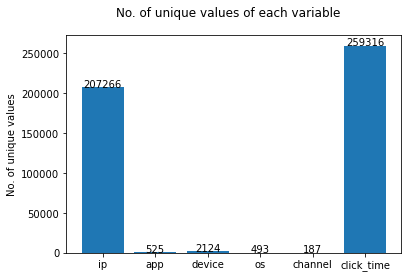

In [16]:
# Count of unique values of variables
fig, ax = plt.subplots()
fig.suptitle('No. of unique values of each variable')
labels = train_sampled.iloc[:,:-1].columns.tolist()

ax.set_ylabel('No. of unique values')
ax.bar(labels, unique_values)

for index, value in enumerate(unique_values):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

Categorical variables (ip, app, device, os, and channel) are encoded as numbers, i.e. each unique category is represented by a unique number. To avoid introducing irrelavant numerical relationship, we need to re-encode these catorical variables. 

However, we observe that all categorical variables have high cardinalities (more than 100 categories). As such, one-hot encoding may not be a feasible choice as it will make the feature space of the encoded dataset to be very huge. Therefore, to avoid this problem, we decided to do **count encoding**, where each category in each categorical variable will be replaced by the count of that category. If the test set has a unknown never seen before categories, it will be replaced by 0.

## Categorical Encoding <a name="catenc"></a>

In [18]:
categorical_features = ['ip', 'app', 'device', 'os', 'channel']

# Normalize the counts here as the count seems too big which may affect gradient descent
count_enc = ce.CountEncoder(cols=categorical_features, handle_unknown='value', normalize=True)
new_train_categories = count_enc.fit_transform(train_sampled[categorical_features])
new_train_categories.columns = ['ip_enc', 'app_enc', 'device_enc', 'os_enc', 'channel_enc']

train_enc = pd.concat([train_sampled, new_train_categories], axis = 1)
train_enc.head()

,ip,app,device,os,channel,click_time,is_attributed,ip_enc,app_enc,device_enc,os_enc,channel_enc
0,304834,20,1,17,259,2017-11-09 15:58:50,0,0.000003,0.009599,0.942435,0.052055,0.030631
1,55874,3,1,13,371,2017-11-09 09:24:01,0,0.000069,0.181819,0.942435,0.214987,0.003278
2,55988,12,1,22,259,2017-11-06 16:25:11,0,0.000046,0.130055,0.942435,0.040222,0.030631
3,204669,15,1,13,245,2017-11-07 00:54:21,0,0.000017,0.085924,0.942435,0.214987,0.047045
4,68632,14,1,19,401,2017-11-07 03:13:22,0,0.000009,0.054620,0.942435,0.238728,0.007474


In [73]:
train_enc.to_csv('./train_enc.csv', index=False)

## EDA on Basic Features <a name="eda2"></a>

After encoding the categorical variables, we are able to do more exploratory data analysis to visualize the difference between normal (is_attributed=1) and fraud (is_attributed=0) classes.

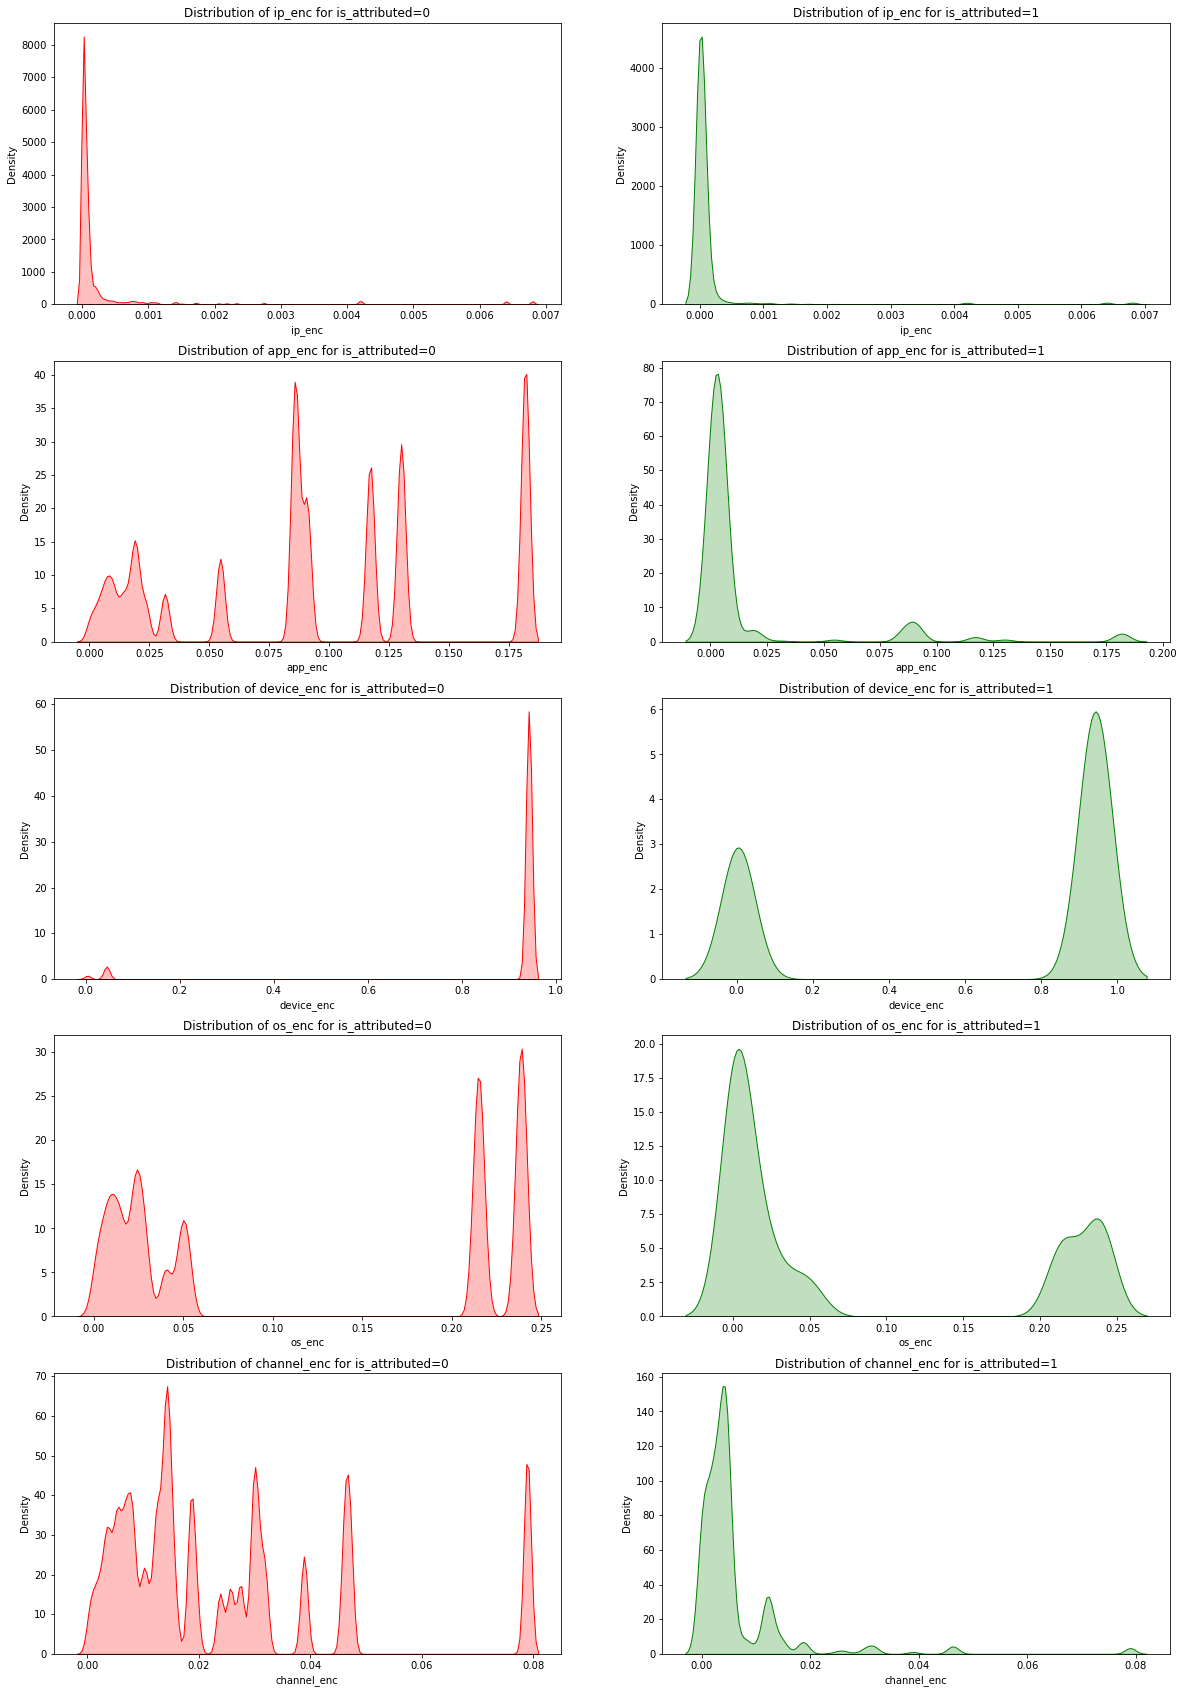

In [23]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(train_enc.columns[7:]):
    plt.subplot(5, 2, index*2+1)
    sns.kdeplot(data=train_enc[train_enc["is_attributed"] == 0], x=var, fill=True, color='red')
    plt.title(f"Distribution of {var} for is_attributed=0")
    plt.subplot(5, 2, index*2+2)
    sns.kdeplot(data=train_enc[train_enc["is_attributed"] == 1], x=var, fill=True, color='green')
    plt.title(f"Distribution of {var} for is_attributed=1")

From the plots above, there is no significant difference in the distribution for ip between normal class and fraud class. Hence, it is not a good feature.

However, there are significant difference in the distribution for app, device, os and channel between normal class and fraud class. Hence, these features are potential candidates for modelling. 

## Feature Engineering <a name="fe"></a>

As we only have 4 candidate features from the dataset, we will be creating new features from the existing features. To decide whether these features will be used for modelling, we will evaluate based on EDA and feature importance in the later part of the project.

In [27]:
train=train_sampled.copy()

In [125]:
train.head(5)

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_os_per_device_trans,uniq_channel_per_device_trans,uniq_ip_per_os_trans,uniq_app_per_os_trans,uniq_device_per_os_trans,uniq_channel_per_os_trans,uniq_ip_per_channel_trans,uniq_app_per_channel_trans,uniq_device_per_channel_trans,uniq_os_per_channel_trans
0,304834,20,1,17,259,2017-11-09 15:58:50,0,9,15,58,...,1.0,1.0,0.656630,0.587361,0.003413,0.988024,0.781105,0.018182,0.003131,0.915556
1,55874,3,1,13,371,2017-11-09 09:24:01,0,9,9,24,...,1.0,1.0,0.946606,0.765799,0.003413,0.994012,0.331738,0.013636,0.002505,0.488889
2,55988,12,1,22,259,2017-11-06 16:25:11,0,6,16,25,...,1.0,1.0,0.619204,0.550186,0.003413,0.934132,0.781105,0.018182,0.003131,0.915556
3,204669,15,1,13,245,2017-11-07 00:54:21,0,7,0,54,...,1.0,1.0,0.946606,0.765799,0.003413,0.994012,0.799959,0.004545,0.003131,0.551111
4,68632,14,1,19,401,2017-11-07 03:13:22,0,7,3,13,...,1.0,1.0,1.000000,0.743494,0.003413,1.000000,0.560904,0.004545,0.000626,0.524444


### Extract time features from click_time

In [16]:
# Create day, hour, minute, second features
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime
train['day'] = train_datetime.dt.day
train['hour'] = train_datetime.dt.hour
train['minute'] = train_datetime.dt.minute
train['second'] = train_datetime.dt.second

### Unique count features

Features with the name *uniq_agg_var_per_by_var* represent the number of unique values of agg_var in certain by_var groups.

In [54]:
# Unique counts
def agg_unique(df, group_cols, unique_col, name):
  grp = df[group_cols+[unique_col]].groupby(group_cols)[unique_col].nunique().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df

In [55]:
# Group by single feature
for by_var in ['ip', 'app', 'device', 'os', 'channel', 'hour']:
    for agg_var in ['ip', 'app', 'device', 'os', 'channel', 'hour']:
        if by_var != agg_var:
            print(f">> Creating uniq_{agg_var}_per_{by_var}")
            train = agg_unique(train, [by_var], agg_var, f"uniq_{agg_var}_per_{by_var}")

>> Creating uniq_app_per_ip
>> Creating uniq_device_per_ip
>> Creating uniq_os_per_ip
>> Creating uniq_channel_per_ip
>> Creating uniq_hour_per_ip
>> Creating uniq_ip_per_app
>> Creating uniq_device_per_app
>> Creating uniq_os_per_app
>> Creating uniq_channel_per_app
>> Creating uniq_hour_per_app
>> Creating uniq_ip_per_device
>> Creating uniq_app_per_device
>> Creating uniq_os_per_device
>> Creating uniq_channel_per_device
>> Creating uniq_hour_per_device
>> Creating uniq_ip_per_os
>> Creating uniq_app_per_os
>> Creating uniq_device_per_os
>> Creating uniq_channel_per_os
>> Creating uniq_hour_per_os
>> Creating uniq_ip_per_channel
>> Creating uniq_app_per_channel
>> Creating uniq_device_per_channel
>> Creating uniq_os_per_channel
>> Creating uniq_hour_per_channel
>> Creating uniq_ip_per_hour
>> Creating uniq_app_per_hour
>> Creating uniq_device_per_hour
>> Creating uniq_os_per_hour
>> Creating uniq_channel_per_hour


In [56]:
# Min max transformation
for var in train[train.columns[11:]]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

In [138]:
# Group by multiple features
for by_var in [['ip','day'], ['ip','app'], ['ip', 'device', 'os']]:
    for agg_var in ['ip', 'app', 'device', 'os', 'channel', 'hour']:
        if not (agg_var in by_var):
            print(f">> Creating uniq_{agg_var}_per_{'_'.join(by_var)}")
            train = agg_unique(train, by_var, agg_var, f"uniq_{agg_var}_per_{'_'.join(by_var)}")

>> Creating uniq_app_per_ip_day
>> Creating uniq_device_per_ip_day
>> Creating uniq_os_per_ip_day
>> Creating uniq_channel_per_ip_day
>> Creating uniq_hour_per_ip_day
>> Creating uniq_device_per_ip_app
>> Creating uniq_os_per_ip_app
>> Creating uniq_channel_per_ip_app
>> Creating uniq_hour_per_ip_app
>> Creating uniq_app_per_ip_device_os
>> Creating uniq_channel_per_ip_device_os
>> Creating uniq_hour_per_ip_device_os


In [140]:
# Min max transformation
for var in train[train.columns[71:]]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

### Cumulative count features

Features with the name *cum_count_by_var* represent the number of observations appearing before the current observation in certain var groups.

In [5]:
# Cumulative counts
def agg_cum_count(df, group_cols, name):
  grp = df[group_cols].groupby(group_cols).cumcount()
  df[name] = grp.values
  return df

In [6]:
combi = []
for i in range(1, 6):
    combi += list(combinations(['app', 'device', 'os', 'channel', 'hour'], i))

In [9]:
for var in combi:
    print(f">> Creating cum_count_by_{'_'.join(var)}")
    train = agg_cum_count(train, list(var), f"cum_count_by_{'_'.join(var)}")

>> Creating cum_count_by_app
>> Creating cum_count_by_device
>> Creating cum_count_by_os
>> Creating cum_count_by_channel
>> Creating cum_count_by_hour
>> Creating cum_count_by_app_device
>> Creating cum_count_by_app_os
>> Creating cum_count_by_app_channel
>> Creating cum_count_by_app_hour
>> Creating cum_count_by_device_os
>> Creating cum_count_by_device_channel
>> Creating cum_count_by_device_hour
>> Creating cum_count_by_os_channel
>> Creating cum_count_by_os_hour
>> Creating cum_count_by_channel_hour
>> Creating cum_count_by_app_device_os
>> Creating cum_count_by_app_device_channel
>> Creating cum_count_by_app_device_hour
>> Creating cum_count_by_app_os_channel
>> Creating cum_count_by_app_os_hour
>> Creating cum_count_by_app_channel_hour
>> Creating cum_count_by_device_os_channel
>> Creating cum_count_by_device_os_hour
>> Creating cum_count_by_device_channel_hour
>> Creating cum_count_by_os_channel_hour
>> Creating cum_count_by_app_device_os_channel
>> Creating cum_count_by_app_de

In [13]:
# Min max transformation
for var in train.columns[95:]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

### Total count features

Features with the name *var_counts* represent the total number of observations in certain var groups.

In [219]:
# Total counts
def agg_counts(df, group_cols, name):
  grp = df[group_cols].groupby(group_cols).size().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df

In [262]:
combi = []
for i in range(2, 6):
    combi += list(combinations(['app', 'device', 'os', 'channel', 'hour'], i))

In [266]:
for var in combi:
    print(f">> Creating {'_'.join(var)}_counts")
    train = agg_counts(train, list(var), f"{'_'.join(var)}_counts")

>> Creating app_device_counts
>> Creating app_os_counts
>> Creating app_channel_counts
>> Creating app_hour_counts
>> Creating device_os_counts
>> Creating device_channel_counts
>> Creating device_hour_counts
>> Creating os_channel_counts
>> Creating os_hour_counts
>> Creating channel_hour_counts
>> Creating app_device_os_counts
>> Creating app_device_channel_counts
>> Creating app_device_hour_counts
>> Creating app_os_channel_counts
>> Creating app_os_hour_counts
>> Creating app_channel_hour_counts
>> Creating device_os_channel_counts
>> Creating device_os_hour_counts
>> Creating device_channel_hour_counts
>> Creating os_channel_hour_counts
>> Creating app_device_os_channel_counts
>> Creating app_device_os_hour_counts
>> Creating app_device_channel_hour_counts
>> Creating app_os_channel_hour_counts
>> Creating device_os_channel_hour_counts
>> Creating app_device_os_channel_hour_counts


In [269]:
# Min max transformation
for var in train.columns[157:]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

### Time till next click features

Features with name *var_nextClick* represents the difference between click_time of the current observation and the next one in vertain var groups.

In [17]:
def time_till_next(df, group_cols, name):
    df_sub = df[group_cols+['click_time']]
    df[name] = df_sub.groupby(group_cols).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    df[name].fillna(0, inplace=True)
    return df

In [18]:
combi = []
for i in range(1, 6):
    combi += list(combinations(['ip', 'app', 'device', 'os', 'channel'], i))

In [ ]:
for var in combi:
    print(f">> Creating {'_'.join(var)}_nextClick")
    train = time_till_next(train, list(var), f"{'_'.join(var)}_nextClick")

>> Creating ip_nextClick
>> Creating app_nextClick
>> Creating device_nextClick
>> Creating os_nextClick
>> Creating channel_nextClick
>> Creating ip_app_nextClick
>> Creating ip_device_nextClick
>> Creating ip_os_nextClick
>> Creating ip_channel_nextClick
>> Creating app_device_nextClick
>> Creating app_os_nextClick
>> Creating app_channel_nextClick
>> Creating device_os_nextClick
>> Creating device_channel_nextClick
>> Creating os_channel_nextClick
>> Creating ip_app_device_nextClick
>> Creating ip_app_os_nextClick
>> Creating ip_app_channel_nextClick
>> Creating ip_device_os_nextClick
>> Creating ip_device_channel_nextClick
>> Creating ip_os_channel_nextClick
>> Creating app_device_os_nextClick
>> Creating app_device_channel_nextClick
>> Creating app_os_channel_nextClick
>> Creating device_os_channel_nextClick
>> Creating ip_app_device_os_nextClick
>> Creating ip_app_device_channel_nextClick
>> Creating ip_app_os_channel_nextClick


In [377]:
# Min max transformation
for var in train.columns[209:]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

### Combine with encoded categorical variables

In [ ]:
for var in train_enc.columns:
    if "enc" in var:
        train[var] = train_enc[var]

In [419]:
train.to_csv('./train.csv', index=False)

### Extract Min and Max values for newly created features

Since normalization is performed on those newly created features, we need to extract the min and max values of each features in preperation for processing testing set in the later part of the project.

In [92]:
features = ['uniq_app_per_ip_day', 'uniq_os_per_ip_day', 'uniq_channel_per_ip_day',
 'uniq_hour_per_ip_day', 'uniq_os_per_ip_app', 'uniq_channel_per_ip_app',
 'uniq_hour_per_ip_app', 'uniq_app_per_ip_device_os', 'uniq_channel_per_ip_device_os',
 'uniq_hour_per_ip_device_os', 'uniq_app_per_ip', 'uniq_os_per_ip', 'uniq_channel_per_ip',
 'uniq_hour_per_ip', 'uniq_ip_per_app', 'uniq_device_per_app', 'uniq_os_per_app', 'uniq_channel_per_app',
 'uniq_ip_per_device', 'uniq_app_per_device', 'uniq_os_per_device', 'uniq_channel_per_device',
 'uniq_ip_per_os', 'uniq_app_per_os', 'uniq_device_per_os', 'uniq_channel_per_os',
 'uniq_ip_per_channel', 'uniq_app_per_channel', 'uniq_device_per_channel', 'uniq_os_per_channel',
 'ip_nextClick', 'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextClick',
 'ip_app_device_nextClick', 'app_device_counts', 'app_channel_counts', 'app_hour_counts',
 'device_channel_counts', 'device_hour_counts', 'channel_hour_counts',
 'cum_count_by_app', 'cum_count_by_device', 'cum_count_by_channel']
max_values=[]
min_values=[]
for var in features:
    X=train[var]
    max_values.append(X.max(axis=0))
    min_values.append(X.min(axis=0))

In [95]:
df=pd.DataFrame()
df['Features'] = features
df['Max'] = max_values
df['Min'] = min_values

In [101]:
df.to_csv('./minmax_values.csv', index=False)

## Undersampling <a name="undersampling"></a>

In [36]:
# Function to do undersampling
def undersample(train):
  train_0 = train[train["is_attributed"] == 0]
  train_1 = train[train["is_attributed"] == 1]

  train_0_count, train_1_count = train["is_attributed"].value_counts()

  # Under-sample class 0
  train_0_under = train_0.sample(n = train_1_count, random_state = 0)

  # Merge undersampled class 0 and original class 1
  train_under = pd.concat([train_0_under, train_1], axis = 0)
  return train_under

In [444]:
train_undersampled = undersample(train)

train_undersampled.shape

(186454, 56)

In [445]:
train_undersampled.to_csv('./train_undersampled_all.csv', index=False)

## EDA on Newly Created Features <a name="eda3"></a>

After doing feature engineering and undersampling, we can do further EDA in preparation for feature selection.

### Time features from click_time

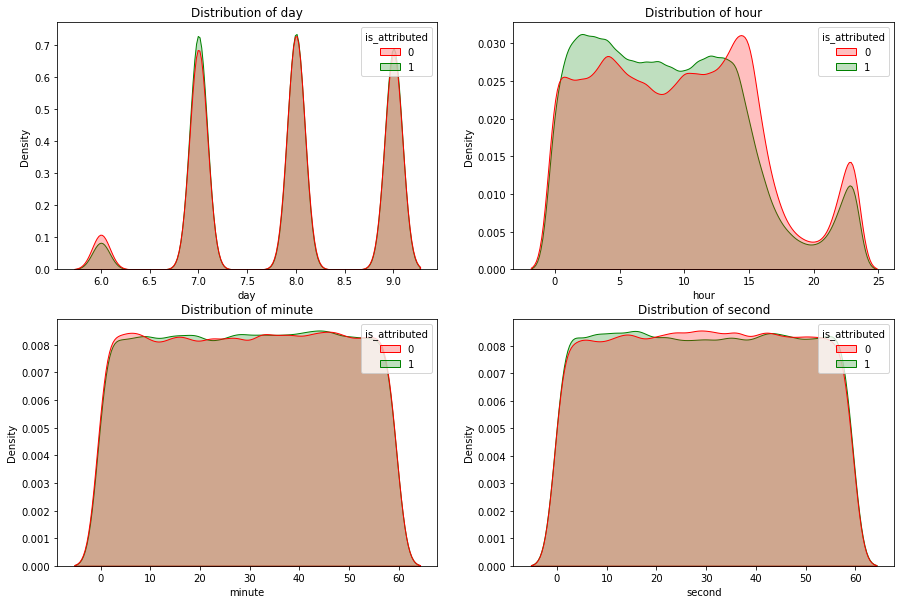

In [215]:
plt.figure(figsize=(15, 10))
for index, var in enumerate(['day', 'hour', 'minute', 'second']):
    plt.subplot(2, 2, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}")
    
plt.show()

From the plots above, these four time-related features alone may not be good features to use as there is not much difference in their distribution between normal and fraud classes. Hence, we will combine them with other features to create new features.

### Unique count features - grouped by single variable

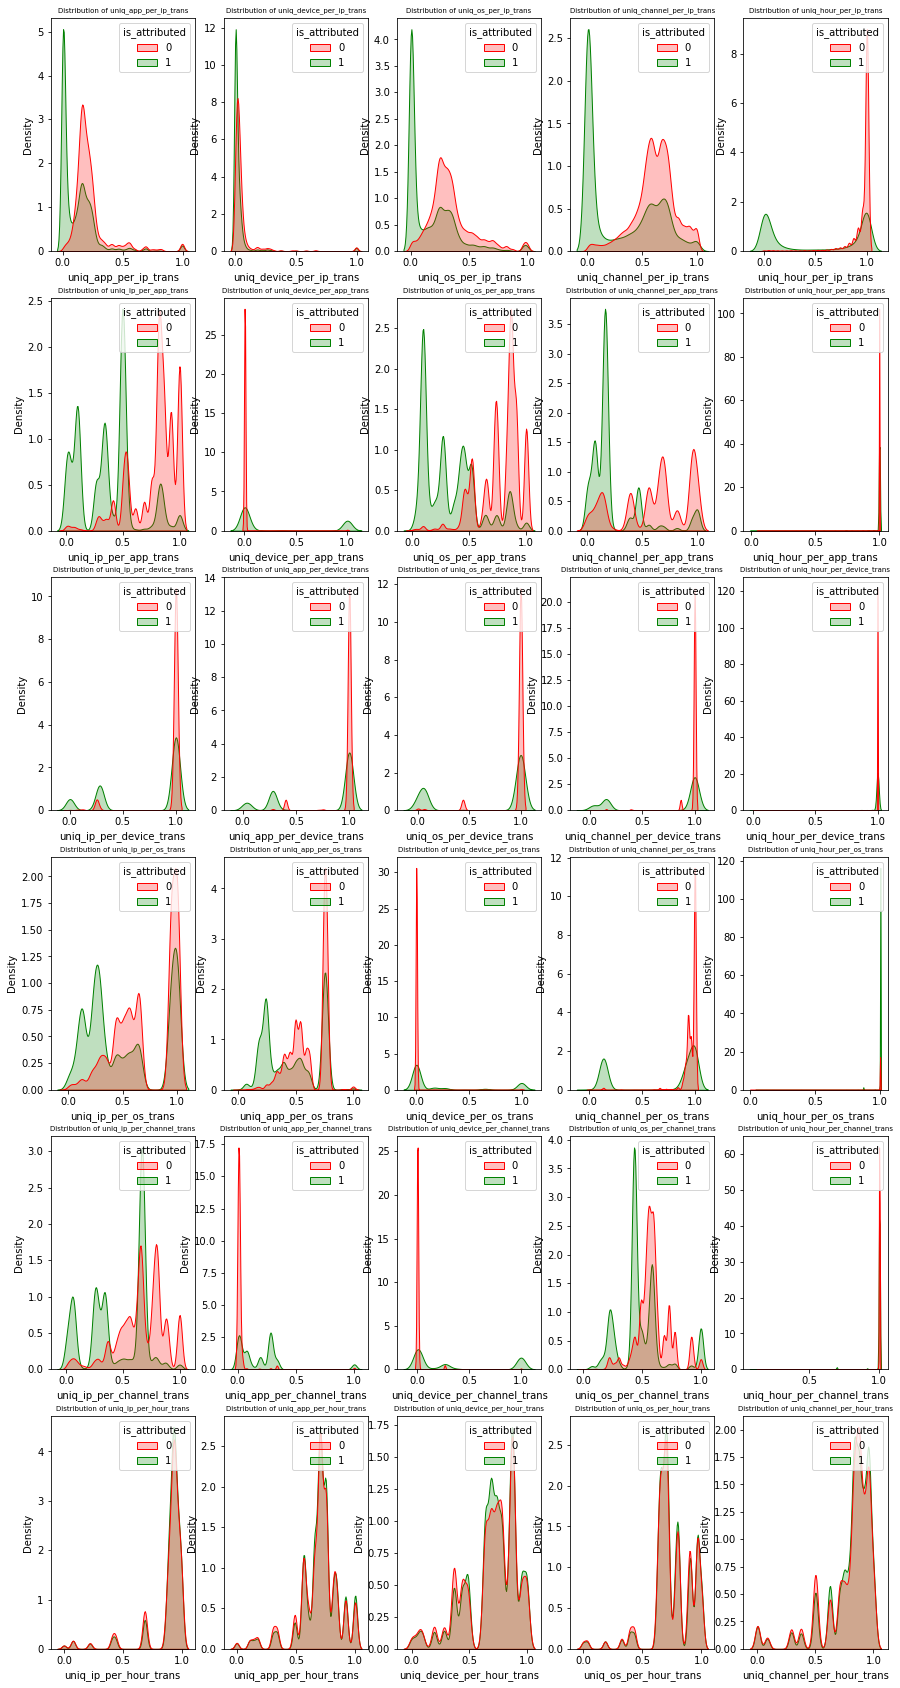

In [84]:
plt.figure(figsize=(15, 30))
for i in range(6):
    for j in range(5):
        plt.subplot(6, 5, i*5+j+1)
        sns.kdeplot(data=train_undersampled, x=train_undersampled.columns[41+i*5+j], 
                    hue="is_attributed", fill=True, palette=('red','green'))
        plt.title(f"Distribution of {train_undersampled.columns[37+i*5+j]}", fontsize = 7)

plt.show()

The following features **may not be good features** as there is no significant difference in their distribution between normal and fraud class: <br/>
'uniq_device_per_ip', <br/>
'uniq_hour_per_app', <br/>
'uniq_hour_per_device', <br/>
'uniq_hour_per_os', <br/>
'uniq_hour_per_channel', <br/>
'uniq_ip_per_hour', 'uniq_app_per_hour', 'uniq_device_per_hour', 'uniq_os_per_hour', 'uniq_channel_per_hour'


Instead, these featurs **may be good features** because there is a some difference in their distribution between normal and fraud class: <br/>
'uniq_app_per_ip', 'uniq_os_per_ip', 'uniq_channel_per_ip', 'uniq_hour_per_ip', <br/>
'uniq_ip_per_app', 'uniq_device_per_app', 'uniq_os_per_app', 'uniqu_channel_per_app', <br/>
'uniq_ip_per_device', 'uniq_app_per_device', 'uniq_os_per_device', 'uniq_channel_per_device', <br/>
'uniq_ip_per_os', 'uni_app_per_os', 'uniq_device_per_os', 'uniq_channel_per_os', <br/>
'uniq_ip_per_channel, 'uniq_app_per_channel', 'uniq_device_per_channel', 'uniq_os_per_channel'.

### Unique count features - grouped by multiple variables

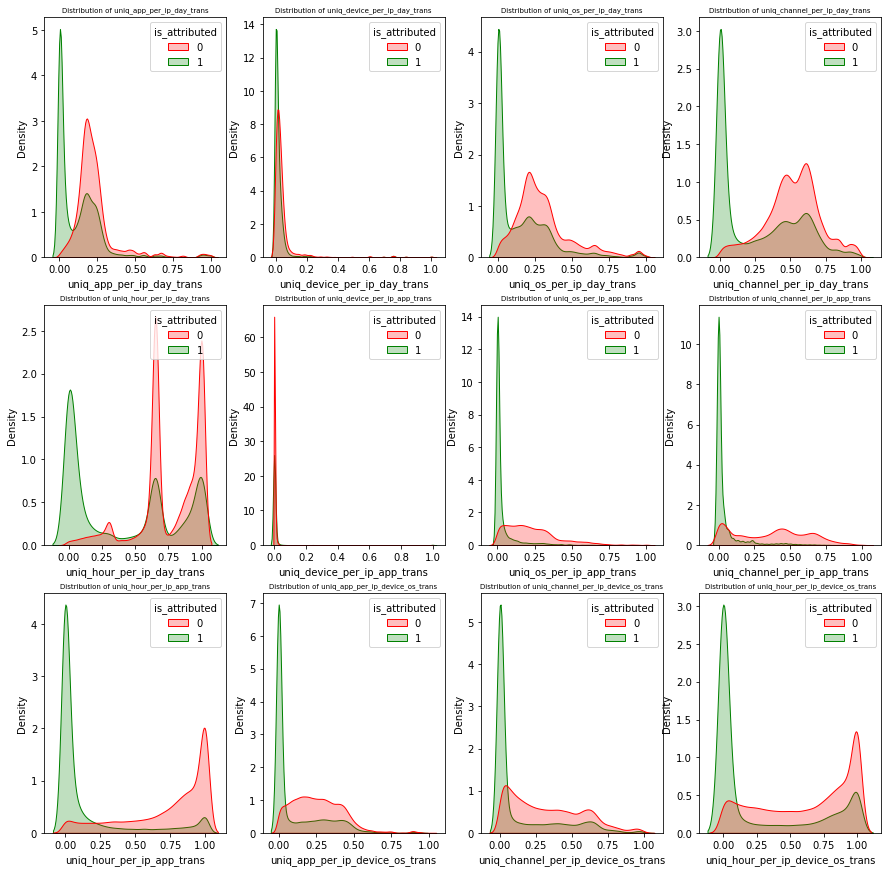

In [146]:
plt.figure(figsize=(15, 15))
for index, var in enumerate(train_undersampled.columns[83:95]):
    plt.subplot(3, 4, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}", fontsize = 7)

plt.show()

The following features **may not be good features** as there is no significant difference in their distribution between normal and fraud class: <br/>
'uniq_device_per_ip_day', <br/>
'uniq_device_per_ip_app'


Instead, these featurs **may be good features** because there is a significant difference in their distribution between normal and fraud class:
‘uniq_app_per_ip_day’, ‘uniq_os_per_ip_day’, ‘uniq_channel_per_ip_day’, ‘uniq_hour_per_ip_day’, <br/>
'uniq_os_per_ip_app’, 'uniq_channel_per_ip_app’, 'uniq_hour_per_ip_app', <br/>
‘uniq_app_per_ip_device_os’, ‘uniq_channel_per_ip_device_os’, ‘uniq_hour_per_ip_device_os’ <br/>

### Cumulative count features

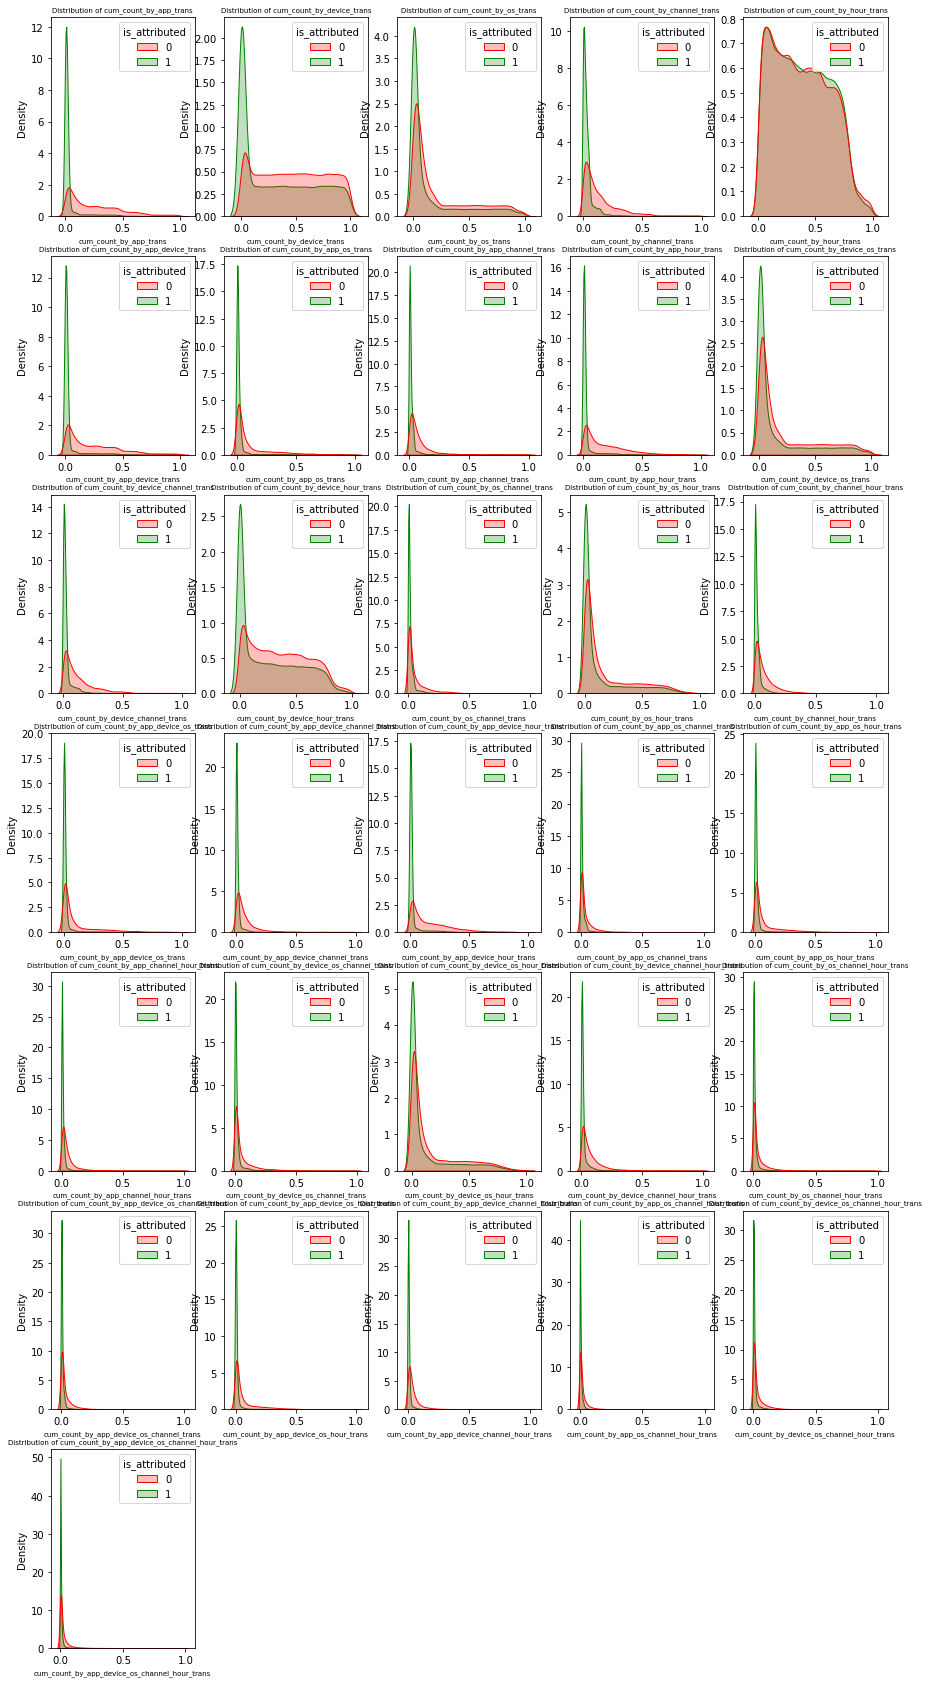

In [293]:
plt.figure(figsize=(15, 30))
for index, var in enumerate(train_undersampled.columns[126:157]):
    plt.subplot(7, 5, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}", fontsize = 7)
    plt.xlabel(var, fontsize = 7)

plt.show()

The following features **may be good features** to use for further analysis: <br/>
'cum_count_by_app', 'cum_count_by_device', 'cum_count_by_channel'

### Total count features

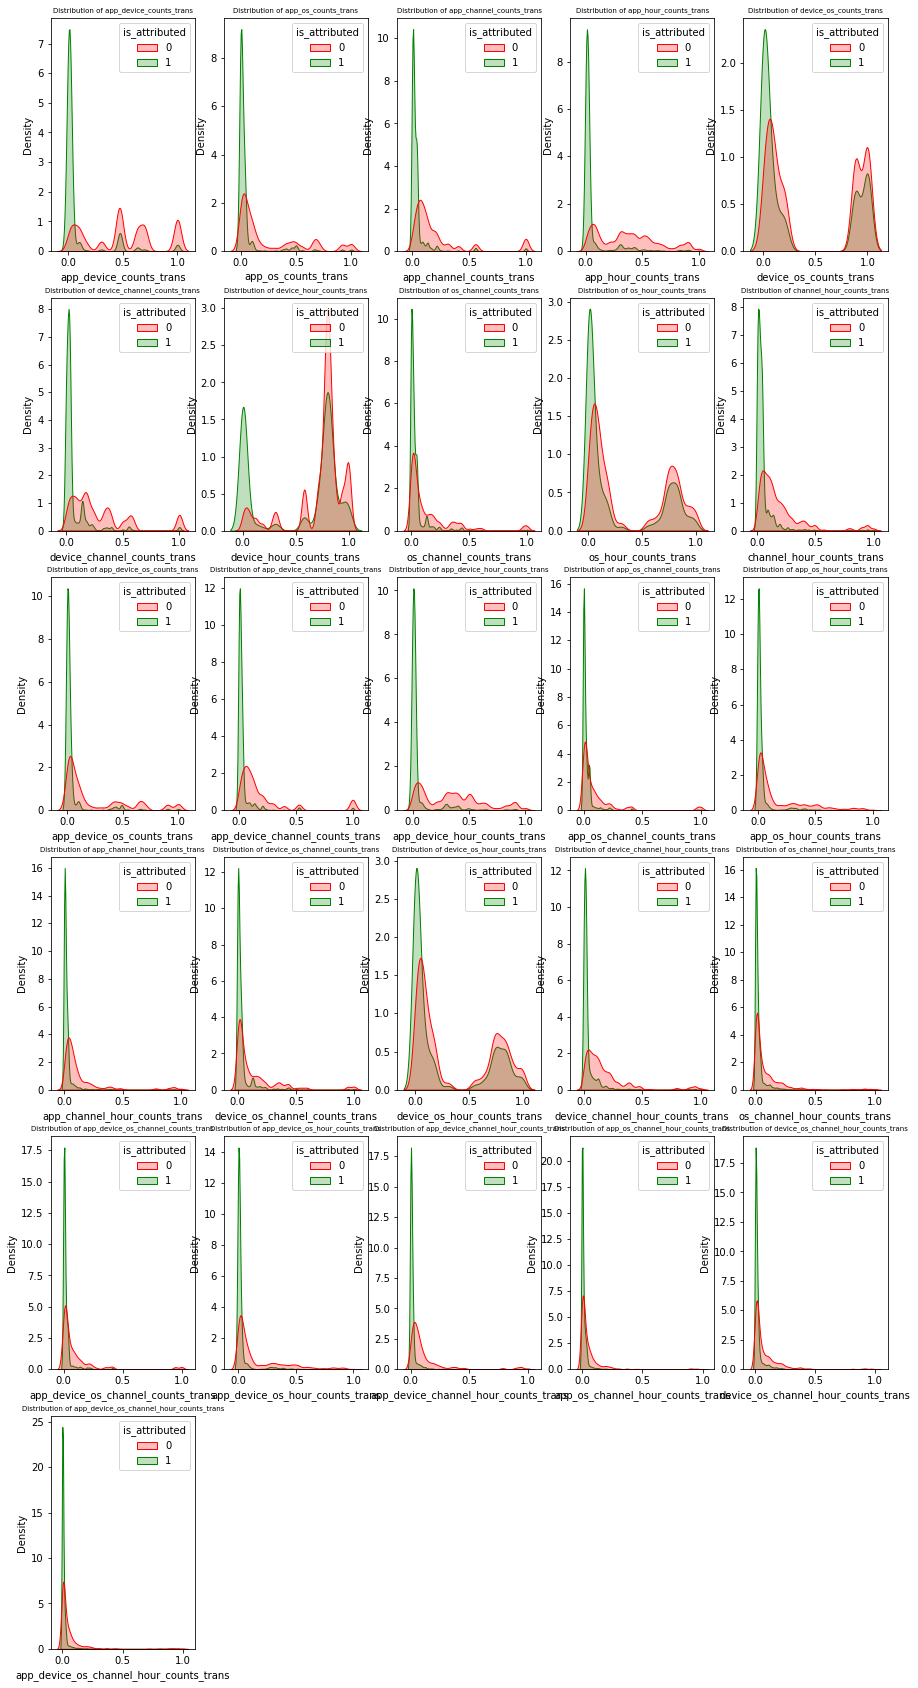

In [273]:
plt.figure(figsize=(15, 30))
for index, var in enumerate(train_undersampled.columns[183:209]):
    plt.subplot(6, 5, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}", fontsize = 7)

plt.show()

The following features **may be good features** to use for further analysis: <br/>
'app_device_counts', 'app_channel_counts', 'app_hour_counts', 'device_channel_counts', 'device_hour_counts', 'channel_hour_counts'

### Time till next click features

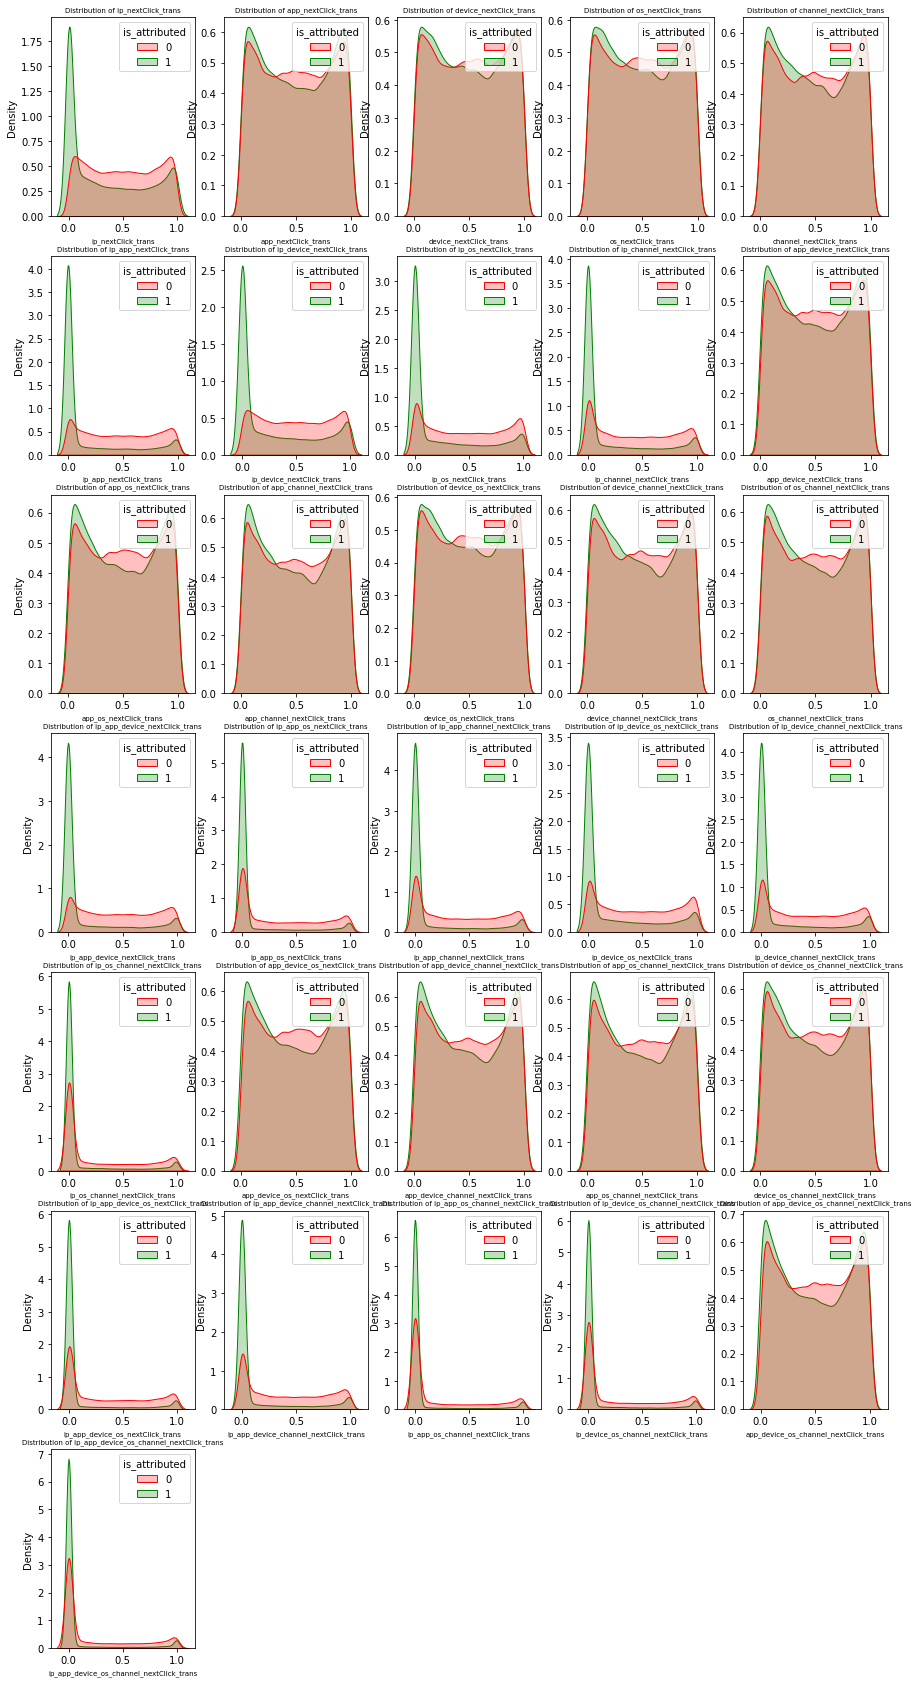

In [387]:
plt.figure(figsize=(15, 30))
for index, var in enumerate(train_undersampled.columns[240:271]):
    plt.subplot(7, 5, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}", fontsize = 7)
    plt.xlabel(var, fontsize = 7)

plt.show()

The following features **may be good features** to use for further analysis: <br/>
'ip_nextClick', <br/>
'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextClick', <br/>
'ip_app_device_nextClick'

### Select features based on EDA

In [ ]:
# Remove non-encoded and non-normalized data
train_new = pd.DataFrame()
for var in train_undersampled.columns:
    if "enc" in var:
        train_new[var[:-4]] = train_undersampled[var]
    if "trans" in var:
        train_new[var[:-6]] = train_undersampled[var]
    if var in ['day', 'hour', 'minute', 'second', 'click_time', 'is_attributed']:
        train_new[var] = train_undersampled[var]

train_undersampled = train_new

In [ ]:
train_undersampled = train_undersampled[['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'day', 'hour', 'minute', 'second', 'uniq_app_per_ip_day',
       'uniq_os_per_ip_day', 'uniq_channel_per_ip_day', 'uniq_hour_per_ip_day',
       'uniq_os_per_ip_app', 'uniq_channel_per_ip_app', 'uniq_hour_per_ip_app',
       'uniq_app_per_ip_device_os', 'uniq_channel_per_ip_device_os',
       'uniq_hour_per_ip_device_os', 'uniq_app_per_ip', 'uniq_os_per_ip',
       'uniq_channel_per_ip', 'uniq_hour_per_ip', 'uniq_ip_per_app',
       'uniq_device_per_app', 'uniq_os_per_app', 'uniq_channel_per_app',
       'uniq_ip_per_device', 'uniq_app_per_device', 'uniq_os_per_device',
       'uniq_channel_per_device', 'uniq_ip_per_os', 'uniq_app_per_os',
       'uniq_device_per_os', 'uniq_channel_per_os', 'uniq_ip_per_channel',
       'uniq_app_per_channel', 'uniq_device_per_channel',
       'uniq_os_per_channel', 'ip_nextClick', 'ip_app_nextClick',
       'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextClick',
       'ip_app_device_nextClick', 'app_device_counts', 'app_channel_counts',
       'app_hour_counts', 'device_channel_counts', 'device_hour_counts',
       'channel_hour_counts', 'cum_count_by_app', 'cum_count_by_device',
       'cum_count_by_channel']]

In [ ]:
train_undersampled.to_csv('./train_undersampled.csv', index=False)

## (Starting Point) Load Undersampled Training Set <a name="train"></a>

In [49]:
train = pd.read_csv('./train_undersampled.csv')
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,ip_app_device_nextClick,app_device_counts,app_channel_counts,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts,cum_count_by_app,cum_count_by_device,cum_count_by_channel
0,0.000048,0.085924,0.942435,0.001422,0.047045,2017-11-07 06:18:26,0,7,6,18,...,0.724951,0.470118,0.404262,0.334755,0.586100,0.788327,0.377761,0.442650,0.936941,0.558279
1,0.000056,0.181819,0.942435,0.214987,0.078942,2017-11-07 03:06:29,0,7,3,6,...,0.404854,1.000000,1.000000,0.875513,1.000000,0.812032,0.905031,0.379847,0.379880,0.379802
2,0.000012,0.117137,0.942435,0.238728,0.013642,2017-11-07 11:15:24,0,7,11,15,...,0.636199,0.635480,0.115387,0.409303,0.171519,0.786015,0.093909,0.028730,0.044519,0.007743
3,0.000033,0.181819,0.942435,0.004142,0.014188,2017-11-08 14:44:58,0,8,14,44,...,0.376301,1.000000,0.089178,0.831484,0.185177,0.984220,0.139886,0.045127,0.045176,0.008119
4,0.000018,0.117137,0.942435,0.021689,0.008188,2017-11-09 10:24:38,0,9,10,24,...,0.106760,0.635480,0.107859,0.439303,0.105567,0.800991,0.041867,0.533432,0.828170,0.085931


In [5]:
train["is_attributed"].value_counts()

0    93227
1    93227
Name: is_attributed, dtype: int64

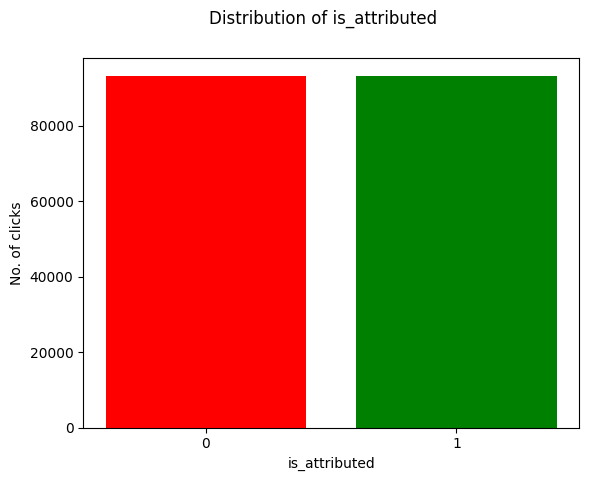

In [69]:
# Obtain counts of each class
data_0, data_1 = train["is_attributed"].value_counts()

# Plot distribution of is_attributed
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']
counts= [data_0, data_1]
ax.set_ylabel('No. of clicks')
ax.set_xlabel("is_attributed")
bars = ax.bar(labels, counts, color = ('red','green'))
plt.show()

## Feature Selection <a name="featureselection"></a>

In [6]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'day', 'hour', 'minute', 'second', 'uniq_app_per_ip_day',
       'uniq_os_per_ip_day', 'uniq_channel_per_ip_day', 'uniq_hour_per_ip_day',
       'uniq_os_per_ip_app', 'uniq_channel_per_ip_app', 'uniq_hour_per_ip_app',
       'uniq_app_per_ip_device_os', 'uniq_channel_per_ip_device_os',
       'uniq_hour_per_ip_device_os', 'uniq_app_per_ip', 'uniq_os_per_ip',
       'uniq_channel_per_ip', 'uniq_hour_per_ip', 'uniq_ip_per_app',
       'uniq_device_per_app', 'uniq_os_per_app', 'uniq_channel_per_app',
       'uniq_ip_per_device', 'uniq_app_per_device', 'uniq_os_per_device',
       'uniq_channel_per_device', 'uniq_ip_per_os', 'uniq_app_per_os',
       'uniq_device_per_os', 'uniq_channel_per_os', 'uniq_ip_per_channel',
       'uniq_app_per_channel', 'uniq_device_per_channel',
       'uniq_os_per_channel', 'ip_nextClick', 'ip_app_nextClick',
       'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextCli

In [7]:
X_train = train.drop(labels = 'is_attributed', axis = 1)
Y_train = train["is_attributed"]

In [8]:
X_train.dtypes

ip                               float64
app                              float64
device                           float64
os                               float64
channel                          float64
click_time                        object
day                                int64
hour                               int64
minute                             int64
second                             int64
uniq_app_per_ip_day              float64
uniq_os_per_ip_day               float64
uniq_channel_per_ip_day          float64
uniq_hour_per_ip_day             float64
uniq_os_per_ip_app               float64
uniq_channel_per_ip_app          float64
uniq_hour_per_ip_app             float64
uniq_app_per_ip_device_os        float64
uniq_channel_per_ip_device_os    float64
uniq_hour_per_ip_device_os       float64
uniq_app_per_ip                  float64
uniq_os_per_ip                   float64
uniq_channel_per_ip              float64
uniq_hour_per_ip                 float64
uniq_ip_per_app 

### Correlation between features

In [9]:
c = X_train.corr().abs()

s = c.unstack()
so = s.sort_values(ascending = False)
so = so.reset_index()
so.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'}, inplace=True)

In [10]:
#remove correlation between the same features
filtered_so = so[so['feature_1'] != so['feature_2']]
filtered_so[filtered_so["correlation"] >= 0.9]

,feature_1,feature_2,correlation
54,uniq_app_per_device,uniq_ip_per_device,0.991723
55,uniq_ip_per_device,uniq_app_per_device,0.991723
56,device,uniq_os_per_device,0.989099
57,uniq_os_per_device,device,0.989099
58,device,uniq_ip_per_device,0.986470
...,...,...,...
125,uniq_os_per_ip,uniq_channel_per_ip,0.906414
126,channel,app_channel_counts,0.904232
127,app_channel_counts,channel,0.904232
128,uniq_os_per_ip_day,uniq_channel_per_ip_day,0.902328


In [50]:
train = train.drop(labels = ['uniq_ip_per_device', 'uniq_os_per_device','uniq_app_per_device',
                                'uniq_os_per_ip_day', 'uniq_channel_per_ip_device_os', 'uniq_app_per_ip_day',
                                'app_device_counts', 'device_channel_counts',
                                'uniq_app_per_device', 'uniq_channel_per_ip_day', 'uniq_channel_per_os',
                                'uniq_ip_per_os', 'uniq_channel_per_device', 'uniq_os_per_ip',
                                'ip_app_device_nextClick', 'app_hour_counts', 'uniq_hour_per_ip_device_os', 
                                'channel_hour_counts', 'uniq_hour_per_ip', 'app_channel_counts'], axis = 1)

Remaining columns

In [12]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'day', 'hour', 'minute', 'second', 'uniq_hour_per_ip_day',
       'uniq_os_per_ip_app', 'uniq_channel_per_ip_app', 'uniq_hour_per_ip_app',
       'uniq_app_per_ip_device_os', 'uniq_app_per_ip', 'uniq_channel_per_ip',
       'uniq_ip_per_app', 'uniq_device_per_app', 'uniq_os_per_app',
       'uniq_channel_per_app', 'uniq_app_per_os', 'uniq_device_per_os',
       'uniq_ip_per_channel', 'uniq_app_per_channel',
       'uniq_device_per_channel', 'uniq_os_per_channel', 'ip_nextClick',
       'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick',
       'ip_channel_nextClick', 'device_hour_counts', 'cum_count_by_app',
       'cum_count_by_device', 'cum_count_by_channel'],
      dtype='object')

'click_time' is dropped due to no patterns observed in the above EDA. This can be due to the fact that observation is only over the span of 4 days.

In [51]:
train = train.drop("click_time", axis = 1)

Reload X_train with the updated train data

In [14]:
X_train = train.drop(labels = 'is_attributed', axis = 1)

### XGBoost Classifier 

In [79]:
from xgboost import XGBClassifier, plot_importance

xgb_model = XGBClassifier(random_state = 0)
xgb_model.fit(X_train, Y_train)
Y_train_pred = xgb_model.predict(X_train)

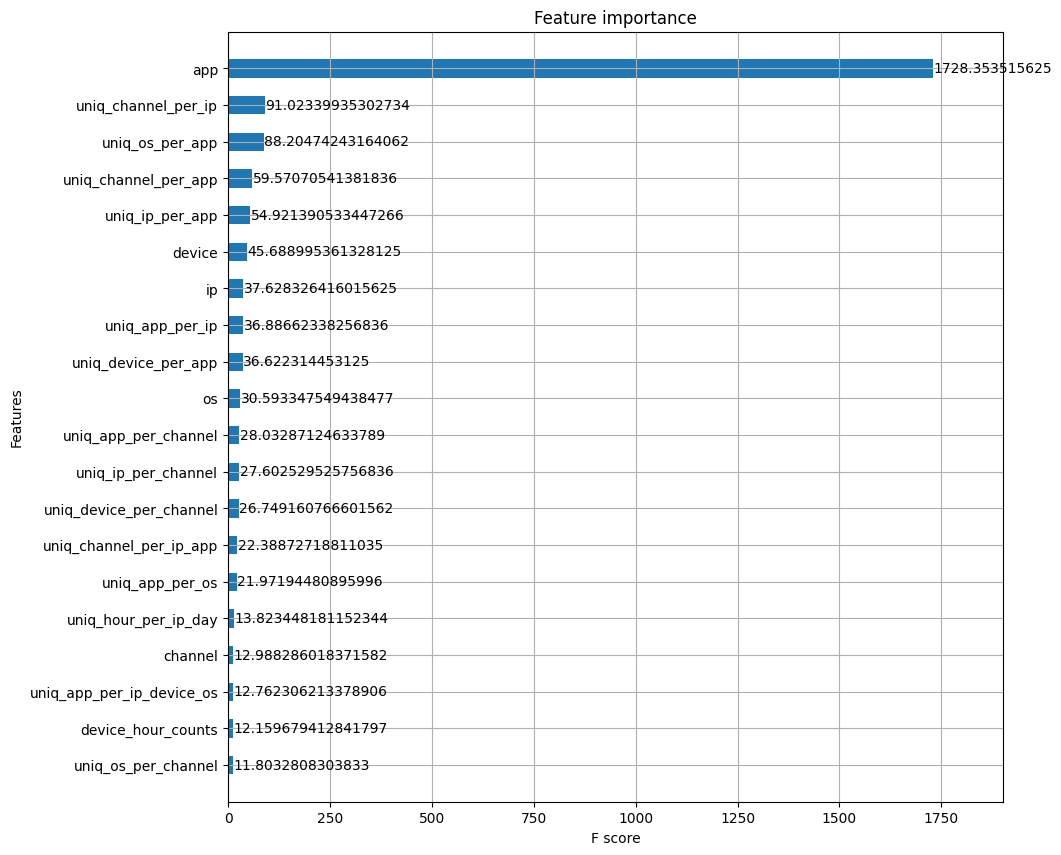

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(xgb_model, max_num_features = 20, height = 0.5, ax = ax,
                importance_type = "gain")
plt.show()

In [81]:
top_features = pd.DataFrame()
top_features['feature'] = X_train.columns
top_features['importance'] = xgb_model.feature_importances_
top_features.sort_values(by = 'importance', ascending=False, inplace=True)

top20_XGB_features = top_features[:20]
top20_XGB_features

,feature,importance
1,app,0.691871
15,uniq_channel_per_ip,0.036437
18,uniq_os_per_app,0.035309
19,uniq_channel_per_app,0.023847
16,uniq_ip_per_app,0.021985
2,device,0.018290
0,ip,0.015063
14,uniq_app_per_ip,0.014766
17,uniq_device_per_app,0.014660
3,os,0.012247


Although 'ip' is one of the top 20 features, we decided to drop 'ip' from our model as there is no significant difference observed between 'ip' in fraud and non-fraud click based on the EDA above.

In [82]:
final_features = list(top20_XGB_features.feature.values[top20_XGB_features.feature.values != 'ip'])

Datasets for model building and evaluation

In [52]:
final_features

['app',
 'uniq_channel_per_ip',
 'uniq_os_per_app',
 'uniq_channel_per_app',
 'uniq_ip_per_app',
 'device',
 'uniq_app_per_ip',
 'uniq_device_per_app',
 'os',
 'uniq_app_per_channel',
 'uniq_ip_per_channel',
 'uniq_device_per_channel',
 'uniq_channel_per_ip_app',
 'uniq_app_per_os',
 'uniq_hour_per_ip_day',
 'channel',
 'uniq_app_per_ip_device_os',
 'device_hour_counts',
 'uniq_os_per_channel']

## Prepare Testing Set <a name="preptest"></a>

The test set needs to be prepared as follows:
- Categorical Encoding
- Feature Engineering (features that seem helpful after EDA on train set)
- Feature selection (features selected using train set) (saved as 'test_final_features.csv')

#### Encode categorical variables

In [10]:
test_sampled = pd.read_csv('./test_sampled.csv')
test_sampled.head()

In [3]:
# encoding test set, unknown categories are filled with 0
categorical_features = ['ip', 'app', 'device', 'os', 'channel']
new_test_cat = count_enc.transform(test_sampled[categorical_features])

new_test_cat.columns = ['ip_enc', 'app_enc', 'device_enc', 'os_enc', 'channel_enc']

test_enc = pd.concat([test_sampled, new_test_cat], axis = 1)

In [1]:
test_enc.to_csv("./test_enc.csv", index=False)

#### Create new features for testing set

In [3]:
test_sampled = pd.read_csv("./test_sampled.csv")

##### Extract time features from clicktime

In [4]:
# Create day, hour, minute, second features
test_datetime = pd.to_datetime(test_sampled['click_time'], format='%Y-%m-%d %H:%M:%S')
test_sampled['click_time'] = test_datetime
test_sampled['day'] = test_datetime.dt.day
test_sampled['hour'] = test_datetime.dt.hour
test_sampled['minute'] = test_datetime.dt.minute
test_sampled['second'] = test_datetime.dt.second
test_sampled.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,second
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,7
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,59
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,34
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,50
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,14


##### Unique counts features (Grp by Single Feature)

In [5]:
#getting the features required
unique_count_features = ['uniq_app_per_ip', 
                         'uniq_os_per_ip',
                         'uniq_channel_per_ip',
                         'uniq_hour_per_ip',
                         'uniq_ip_per_app',
                         'uniq_device_per_app',
                         'uniq_os_per_app',
                         'uniq_channel_per_app',
                         'uniq_ip_per_device',
                         'uniq_app_per_device',
                         'uniq_os_per_device',
                         'uniq_channel_per_device',
                         'uniq_ip_per_os',
                         'uniq_app_per_os',
                         'uniq_device_per_os',
                         'uniq_channel_per_os',
                         'uniq_ip_per_channel',
                         'uniq_app_per_channel',
                         'uniq_device_per_channel',
                         'uniq_os_per_channel']
unique = pd.DataFrame({"unique_count_features": unique_count_features })

#get the unique columns and group by columns
unique["split"] = unique["unique_count_features"].apply(lambda x: x.split("_"))
unique["group_col"] = unique["split"].apply(lambda x: x[3])
unique["unique_col"] = unique["split"].apply(lambda x: x[1])
unique.head()

,unique_count_features,split,group_col,unique_col
0,uniq_app_per_ip,"[uniq, app, per, ip]",ip,app
1,uniq_os_per_ip,"[uniq, os, per, ip]",ip,os
2,uniq_channel_per_ip,"[uniq, channel, per, ip]",ip,channel
3,uniq_hour_per_ip,"[uniq, hour, per, ip]",ip,hour
4,uniq_ip_per_app,"[uniq, ip, per, app]",app,ip


In [6]:
# Unique counts (same function as on the train set)
def agg_unique(df, group_cols, unique_col, name):
  grp = df[group_cols+[unique_col]].groupby(group_cols)[unique_col].nunique().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df

In [7]:
#get unique counts based on above combinations
for i in range(0,len(unique)):
    by_var = unique["group_col"][i]
    agg_var = unique["unique_col"][i]
    name = unique["unique_count_features"][i]
    print(f">>{name}")
    test_sampled = agg_unique(test_sampled, [by_var], agg_var, name)

test_sampled.head()

>>uniq_app_per_ip
>>uniq_os_per_ip
>>uniq_channel_per_ip
>>uniq_hour_per_ip
>>uniq_ip_per_app
>>uniq_device_per_app
>>uniq_os_per_app
>>uniq_channel_per_app
>>uniq_ip_per_device
>>uniq_app_per_device
>>uniq_os_per_device
>>uniq_channel_per_device
>>uniq_ip_per_os
>>uniq_app_per_os
>>uniq_device_per_os
>>uniq_channel_per_os
>>uniq_ip_per_channel
>>uniq_app_per_channel
>>uniq_device_per_channel
>>uniq_os_per_channel


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_os_per_device,uniq_channel_per_device,uniq_ip_per_os,uniq_app_per_os,uniq_device_per_os,uniq_channel_per_os,uniq_ip_per_channel,uniq_app_per_channel,uniq_device_per_channel,uniq_os_per_channel
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,269,173,23707,82,3,149,16976,2,2,80
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,269,173,89252,154,3,163,41028,3,2,110
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,269,173,40485,103,3,154,58309,4,6,153
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,269,173,30179,79,3,148,49802,2,4,118
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,269,173,32568,99,3,154,26020,1,4,83


##### Unique Counts Featires (group by multiple feature)
['uniq_app_per_ip_day',
 'uniq_os_per_ip_day',
 'uniq_channel_per_ip_day',
 'uniq_hour_per_ip_day',
 'uniq_os_per_ip_app',
 'uniq_channel_per_ip_app',
 'uniq_hour_per_ip_app',
 'uniq_app_per_ip_device_os',
 'uniq_channel_per_ip_device_os',
 'uniq_hour_per_ip_device_os']

In [8]:
unique_count_features2 = ['uniq_app_per_ip_day',
                         'uniq_os_per_ip_day',
                         'uniq_channel_per_ip_day',
                         'uniq_hour_per_ip_day',
                         'uniq_os_per_ip_app',
                         'uniq_channel_per_ip_app',
                         'uniq_hour_per_ip_app',
                         'uniq_app_per_ip_device_os',
                         'uniq_channel_per_ip_device_os',
                         'uniq_hour_per_ip_device_os']
unique2 = pd.DataFrame({"unique_count_features": unique_count_features2 })

# get unique cols and group by cols for input to function
unique2["split"] = unique2["unique_count_features"].apply(lambda x: x.split("_"))
unique2["group_col"] = unique2["split"].apply(lambda x: x[3:len(x)])
unique2["unique_col"] = unique2["split"].apply(lambda x: x[1])
unique2.head()

,unique_count_features,split,group_col,unique_col
0,uniq_app_per_ip_day,"[uniq, app, per, ip, day]","[ip, day]",app
1,uniq_os_per_ip_day,"[uniq, os, per, ip, day]","[ip, day]",os
2,uniq_channel_per_ip_day,"[uniq, channel, per, ip, day]","[ip, day]",channel
3,uniq_hour_per_ip_day,"[uniq, hour, per, ip, day]","[ip, day]",hour
4,uniq_os_per_ip_app,"[uniq, os, per, ip, app]","[ip, app]",os


In [9]:
for i in range(0,len(unique2)):
    by_var = unique2["group_col"][i]
    agg_var = unique2["unique_col"][i]
    name = unique2["unique_count_features"][i]
    print(f">>{name}")
    test_sampled = agg_unique(test_sampled, by_var, agg_var, name)
    
test_sampled.head()

>>uniq_app_per_ip_day
>>uniq_os_per_ip_day
>>uniq_channel_per_ip_day
>>uniq_hour_per_ip_day
>>uniq_os_per_ip_app
>>uniq_channel_per_ip_app
>>uniq_hour_per_ip_app
>>uniq_app_per_ip_device_os
>>uniq_channel_per_ip_device_os
>>uniq_hour_per_ip_device_os


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_app_per_ip_day,uniq_os_per_ip_day,uniq_channel_per_ip_day,uniq_hour_per_ip_day,uniq_os_per_ip_app,uniq_channel_per_ip_app,uniq_hour_per_ip_app,uniq_app_per_ip_device_os,uniq_channel_per_ip_device_os,uniq_hour_per_ip_device_os
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,23,25,58,16,15,13,18,5,7,5
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,19,18,42,18,18,17,19,18,45,17
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,11,14,30,19,10,5,10,7,10,6
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,23,23,55,23,11,4,19,3,3,3
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,14,12,20,13,5,5,7,3,3,2


##### Cumulative Count Features
['cum_count_by_app', 'cum_count_by_device','cum_count_by_channel']

In [10]:
# Cumulative counts
def agg_cum_count(df, group_cols, name):
    grp = df[group_cols].groupby(group_cols).cumcount()
    df[name] = grp.values
    return df

In [11]:
combi = ['app', 'device', 'channel']

for var in combi:
    print(f">> Creating cum_count_by_{var}")
    test_sampled = agg_cum_count(test_sampled, [var], f"cum_count_by_{var}")

test_sampled.head()

>> Creating cum_count_by_app
>> Creating cum_count_by_device
>> Creating cum_count_by_channel


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_hour_per_ip_day,uniq_os_per_ip_app,uniq_channel_per_ip_app,uniq_hour_per_ip_app,uniq_app_per_ip_device_os,uniq_channel_per_ip_device_os,uniq_hour_per_ip_device_os,cum_count_by_app,cum_count_by_device,cum_count_by_channel
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,16,15,13,18,5,7,5,0,0,0
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,18,18,17,19,18,45,17,0,1,0
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,19,10,5,10,7,10,6,0,2,0
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,23,11,4,19,3,3,3,1,3,0
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,13,5,5,7,3,3,2,0,4,0


##### Total Counts Features

['app_device_counts', 'app_channel_counts', 'app_hour_counts', 'device_channel_counts', 'device_hour_counts', 'channel_hour_counts']

In [12]:
# Total counts
def agg_counts(df, group_cols, name):
  grp = df[group_cols].groupby(group_cols).size().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df

In [13]:
combi = [["app", "device"],
         ["app", "channel"],
         ["app", "hour"],
         ["device", "channel"],
         ["device", "hour"],
         ["channel", "hour"]]

for var in combi:
    print(f">> Creating {'_'.join(var)}_counts")
    test_sampled = agg_counts(test_sampled, list(var), f"{'_'.join(var)}_counts")

test_sampled.head()

>> Creating app_device_counts
>> Creating app_channel_counts
>> Creating app_hour_counts
>> Creating device_channel_counts
>> Creating device_hour_counts
>> Creating channel_hour_counts


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_hour_per_ip_device_os,cum_count_by_app,cum_count_by_device,cum_count_by_channel,app_device_counts,app_channel_counts,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,5,0,0,0,777223,29820,39444,29697,467031,1636
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,17,0,1,0,1658476,64432,108947,133760,478562,7271
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,6,0,2,0,767062,399294,38055,398939,465927,18942
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,3,1,3,0,767062,166254,43164,237603,420984,10483
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,2,0,4,0,794967,63513,53107,58633,444611,2948


##### Time till next click feature

['ip_nextClick', 'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextClick', 'ip_app_device_nextClick',]

In [14]:
def time_till_next(df, group_cols, name):
    df_sub = df[group_cols+['click_time']]
    df[name] = df_sub.groupby(group_cols).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    df[name].fillna(0, inplace=True)
    return df

In [15]:
combi = [["ip"],
         ["ip", "app"],
         ["ip", "device"],
         ["ip", "os"],
         ["ip", "channel"],
         ["ip", "app", "device"]]

for var in combi:
    print(f">> Creating {'_'.join(var)}_nextClick")
    test_sampled = time_till_next(test_sampled, var, f"{'_'.join(var)}_nextClick")

test_sampled.head()

>> Creating ip_nextClick
>> Creating ip_app_nextClick
>> Creating ip_device_nextClick
>> Creating ip_os_nextClick
>> Creating ip_channel_nextClick
>> Creating ip_app_device_nextClick


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts,ip_nextClick,ip_app_nextClick,ip_device_nextClick,ip_os_nextClick,ip_channel_nextClick,ip_app_device_nextClick
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,39444,29697,467031,1636,31945.0,26242.0,31945.0,34837.0,0.0,26242.0
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,108947,133760,478562,7271,38780.0,21921.0,38780.0,64119.0,34514.0,21921.0
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,38055,398939,465927,18942,14807.0,6466.0,14807.0,4961.0,6466.0,6466.0
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,43164,237603,420984,10483,373.0,10809.0,373.0,69966.0,10809.0,10809.0
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,53107,58633,444611,2948,40571.0,1946.0,40571.0,78833.0,1946.0,1946.0


##### End of feature engineering on test set (save to csv file)

In [16]:
test_sampled.to_csv("test_features.csv", index=False)

#### Min-Max Scaling on newly created features

Usage of the min and max values of features obtained from train set

In [17]:
test_sampled = pd.read_csv("test_features.csv")
min_max = pd.read_csv("minmax_values.csv")
min_max.head()

,Features,Max,Min
0,uniq_app_per_ip_day,138.0,1.0
1,uniq_os_per_ip_day,120.0,1.0
2,uniq_channel_per_ip_day,139.0,1.0
3,uniq_hour_per_ip_day,24.0,1.0
4,uniq_os_per_ip_app,106.0,1.0


In [18]:
def min_max_scale(test, min_max):
    for i in range(0, len(min_max)):
        min = min_max["Min"][i]
        max = min_max["Max"][i]
        feature = min_max["Features"][i]
        test[feature] = (test[feature] - min)/(max - min)
    return test

In [19]:
test = min_max_scale(test_sampled, min_max)
test.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts,ip_nextClick,ip_app_nextClick,ip_device_nextClick,ip_os_nextClick,ip_channel_nextClick,ip_app_device_nextClick
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,0.081967,0.010310,0.203400,0.006304,0.369738,0.303730,0.369738,0.403211,0.000000,0.303730
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,0.226402,0.046437,0.208422,0.028030,0.448848,0.253718,0.448848,0.742127,0.399472,0.253718
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,0.079080,0.138499,0.202919,0.073028,0.171379,0.074839,0.171379,0.057420,0.074839,0.074839
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,0.089698,0.082488,0.183346,0.040414,0.004317,0.125106,0.004317,0.809801,0.125106,0.125106
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,0.110360,0.020355,0.193636,0.011362,0.469577,0.022523,0.469577,0.912430,0.022523,0.022523


#### Combine with Categorical Encoding

In [21]:
test_enc  = pd.read_csv("test_enc.csv")

In [22]:
cat_features = ['ip', 'app', 'device', 'os', 'channel']
cat_features_enc = ['ip_enc', 'app_enc', 'device_enc', 'os_enc', 'channel_enc']

for i in range(0,len(cat_features)):
    test[cat_features[i]] = test_enc[cat_features_enc[i]]

test.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts,ip_nextClick,ip_app_nextClick,ip_device_nextClick,ip_os_nextClick,ip_channel_nextClick,ip_app_device_nextClick
0,0.000053,0.085924,0.942435,0.009001,0.003183,2017-11-09 03:29:07,0,9,3,29,...,0.081967,0.010310,0.203400,0.006304,0.369738,0.303730,0.369738,0.403211,0.000000,0.303730
1,0.000027,0.181819,0.942435,0.238728,0.014188,2017-11-08 05:42:59,0,8,5,42,...,0.226402,0.046437,0.208422,0.028030,0.448848,0.253718,0.448848,0.742127,0.399472,0.253718
2,0.000020,0.085729,0.942435,0.022487,0.046148,2017-11-07 02:56:34,0,7,2,56,...,0.079080,0.138499,0.202919,0.073028,0.171379,0.074839,0.171379,0.057420,0.074839,0.074839
3,0.000044,0.085729,0.942435,0.011979,0.025664,2017-11-07 09:45:50,0,7,9,45,...,0.089698,0.082488,0.183346,0.040414,0.004317,0.125106,0.004317,0.809801,0.125106,0.125106
4,0.000006,0.090708,0.942435,0.013570,0.006714,2017-11-09 12:32:14,0,9,12,32,...,0.110360,0.020355,0.193636,0.011362,0.469577,0.022523,0.469577,0.912430,0.022523,0.022523


#### Convert Processed Test Set to CSV file

In [23]:
test.to_csv('./test_processed.csv', index=False)

#### Select features for test set (using features selected from training data)

In [18]:
final_features = ['is_attributed',
                  'app',
                  'uniq_channel_per_ip',
                  'uniq_os_per_app',
                  'uniq_channel_per_app',
                  'uniq_ip_per_app',
                  'device',
                  'uniq_app_per_ip',
                  'uniq_device_per_app',
                  'os',
                  'uniq_app_per_channel',
                  'uniq_ip_per_channel',
                  'uniq_device_per_channel',
                  'uniq_channel_per_ip_app',
                  'uniq_app_per_os',
                  'uniq_hour_per_ip_day',
                  'channel',
                  'uniq_app_per_ip_device_os',
                  'device_hour_counts',
                  'uniq_os_per_channel']

In [19]:
test = pd.read_csv('./test_processed.csv')
test_final_features = test[final_features]

In [21]:
test_final_features.to_csv("./test_final_features.csv", index = False)

## Load train and test set

In [66]:
#training
x_train = train[final_features]
y_train = train["is_attributed"]

In [54]:
#testing
test = pd.read_csv("test_final_features.csv")
x_test = test.drop("is_attributed", axis = 1)
y_test = test["is_attributed"]

## Model Building <a name="modelbuilding"></a>

The following models will be evaluated for this classification problem:
1. Logistic Regression
2. K Nearest Neighbours (KNN)
3. Neural Network
4. Random Forest Classifier
5. XGBoost Classifier

In [46]:
# Log Reg
from sklearn.linear_model import LogisticRegression

# KNN
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

# SVM Classifier
from sklearn.svm import SVC

# Neural Network
from keras.models import Sequential
from keras.layers import Dense

# Tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [55]:
def evaluation_metrics(y_actual, y_pred, y_score):
    cm = metrics.confusion_matrix(y_actual, y_pred)
    accuracy = metrics.accuracy_score(y_actual, y_pred)
    precision = metrics.precision_score(y_actual, y_pred)
    recall = metrics.recall_score(y_actual, y_pred)
    f2 = metrics.fbeta_score(y_actual, y_pred, beta=2.0)
    roc_auc = metrics.roc_auc_score(y_actual, y_score)
    
    dct = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F2': f2,
        'ROC_AUC': roc_auc
    }
    
    # Confusion matrix
    print('Confusion matrix:\n', cm, '\n')
    
    # Accuracy
    print('Accuracy:', accuracy, '\n')
    
    # Precision
    print('Precision:', precision, '\n')
    
    # Recall
    print('Recall:', recall, '\n')
    
    # F2 Score
    print('F2 Score:', f2, '\n')
    
    # ROC_AUC Score
    print('ROC_AUC Score:', roc_auc)
    
    return dct

### Logistic Regression <a name="lr"></a>

Baseline model with 19 features

In [56]:
lr = LogisticRegression(random_state=0, max_iter = 2000)

lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_train_pred_score = lr.predict_proba(x_train)[:, 1]

In [57]:
evaluation_metrics(y_train,y_train_pred_lr, y_train_pred_score)

Confusion matrix:
 [[88176  5051]
 [11861 81366]] 

Accuracy: 0.9092966629838996 

Precision: 0.941550852262865 

Recall: 0.8727729091357654 

F2 Score: 0.8857127306373481 

ROC_AUC Score: 0.9511534616781476


{'Accuracy': 0.9092966629838996,
 'Precision': 0.941550852262865,
 'Recall': 0.8727729091357654,
 'F2': 0.8857127306373481,
 'ROC_AUC': 0.9511534616781476}

Tuned model

In [61]:
y_train = train['is_attributed']
evaluation_scores = [['num_features', 'roc_auc_score', 'f2']]
for i in range(19,3,-5):
    x_train_trial = train[final_features[:i]]
    lr = LogisticRegression(random_state=0, max_iter=2000)
    param_grid = {'penalty' : ['l2','none'],
              'C' : np.logspace(-2, 2, 5),
              'solver' : ['sag','saga']}
    clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, n_jobs = -1)
    lr_tuned = clf_lr.fit(x_train_trial,y_train)
    # summarize results
    print("For %d features, best: %f using %s \n" % (i, lr_tuned.best_score_, lr_tuned.best_params_))
    y_train_pred_tunedlr = lr_tuned.predict(x_train_trial)
    y_train_pred_score = lr_tuned.predict_proba(x_train_trial)[:, 1]
    evaluation = evaluation_metrics(y_train,y_train_pred_tunedlr, y_train_pred_score)
    evaluation
    roc_auc = evaluation['ROC_AUC']
    f2 =  evaluation['F2']
    evaluation_scores.append([i, roc_auc, f2])    
evaluation_scores = pd.DataFrame(evaluation_scores[1:],columns=roc_auc_scores[0])

For 19 features, best: 0.909511 using {'C': 0.01, 'penalty': 'none', 'solver': 'sag'}
Confusion matrix:
 [[88164  5063]
 [11807 81420]] 

Accuracy: 0.9095219196155621 

Precision: 0.9414567024733185 

Recall: 0.8733521404743261 

F2 Score: 0.8861732162798139 

ROC_AUC Score: 0.9510093282556036
For 14 features, best: 0.908229 using {'C': 10.0, 'penalty': 'l2', 'solver': 'saga'}
Confusion matrix:
 [[88020  5207]
 [11905 81322]] 

Accuracy: 0.9082240123569352 

Precision: 0.939823642940517 

Recall: 0.8723009428599011 

F2 Score: 0.8850179676430066 

ROC_AUC Score: 0.9496057681836192
For 9 features, best: 0.900335 using {'C': 0.01, 'penalty': 'none', 'solver': 'sag'}
Confusion matrix:
 [[87635  5592]
 [13002 80225]] 

Accuracy: 0.9002756712111298 

Precision: 0.9348380856939768 

Recall: 0.8605339654821028 

F2 Score: 0.874434574091231 

ROC_AUC Score: 0.9477487679469856
For 4 features, best: 0.881622 using {'C': 10.0, 'penalty': 'l2', 'solver': 'sag'}
Confusion matrix:
 [[85537  7690]
 [

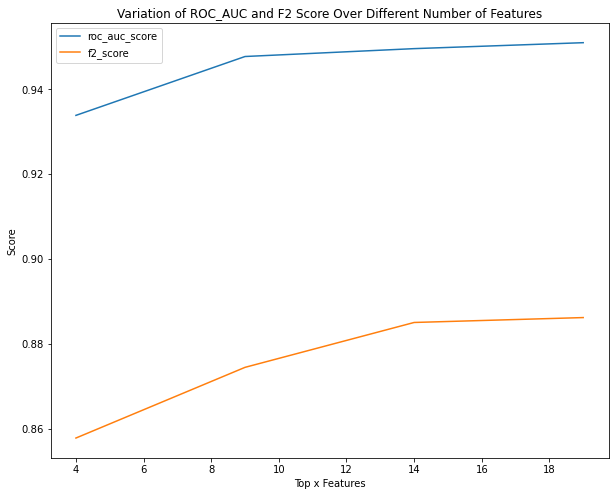

In [75]:
fig, ax = plt.subplots(figsize=(10,8))
x = evaluation_scores['num_features']
plt.plot(x, evaluation_scores['roc_auc_score'], label = "roc_auc_score")
plt.plot(x, evaluation_scores['f2'], label = "f2_score")
plt.title("Variation of ROC_AUC and F2 Score Over Different Number of Features")
plt.xlabel("Top x Features")
plt.ylabel("Score")
plt.legend()
plt.show()

In [63]:
final_9_features = final_features[:9]

In [70]:
#since cv with regularisation gives a slightly better cv score:
lr_tuned = LogisticRegression(random_state=0, max_iter=2000, C = 0.01, penalty= 'none', solver= 'sag')

lr_tuned.fit(x_train[final_9_features], y_train)
y_train_pred_tunedlr = lr_tuned.predict(x_train[final_9_features])
y_train_pred_score = lr_tuned.predict_proba(x_train[final_9_features])[:,1]
evaluation_metrics(y_train,y_train_pred_tunedlr, y_train_pred_score)

Confusion matrix:
 [[87635  5592]
 [13002 80225]] 

Accuracy: 0.9002756712111298 

Precision: 0.9348380856939768 

Recall: 0.8605339654821028 

F2 Score: 0.874434574091231 

ROC_AUC Score: 0.9477487679469856


{'Accuracy': 0.9002756712111298,
 'Precision': 0.9348380856939768,
 'Recall': 0.8605339654821028,
 'F2': 0.874434574091231,
 'ROC_AUC': 0.9477487679469856}

In [73]:
#check on test data
y_test_pred = lr_tuned.predict(x_test[final_9_features])
y_test_pred_score = lr_tuned.predict_proba(x_test[final_9_features])[:,1]

In [74]:
evaluation_metrics(y_test,y_test_pred, y_test_pred_score)

Confusion matrix:
 [[1729218 7697526]
 [    324   22983]] 

Accuracy: 0.18541709457441025 

Precision: 0.0029768762655415595 

Recall: 0.9860985969880294 

F2 Score: 0.014706791385479189 

ROC_AUC Score: 0.9338560722844573


{'Accuracy': 0.18541709457441025,
 'Precision': 0.0029768762655415595,
 'Recall': 0.9860985969880294,
 'F2': 0.014706791385479189,
 'ROC_AUC': 0.9338560722844573}

### K Nearest Neighbours (KNN) <a name="knn"></a>

Baseline with 9 features

In [14]:
X_train_9 = X_train[final_features[:9]]

In [16]:
#fit KNN classifier to the training set
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
knn.fit(X_train_9, y_train)
#predict the train set
y_pred = knn.predict(X_train_9)
y_pred_score = knn.predict_proba(X_train_9)[:, 1]
#compute evaluation metrics
knn_basic = evaluation_metrics(y_train, y_pred, y_pred_score)

Confusion matrix:
 [[89968  3259]
 [12761 80466]] 

Accuracy: 0.9140806847801602 

Precision: 0.9610749477455957 

Recall: 0.8631190534930868 

F2 Score: 0.8810795540401153 

ROC_AUC Score: 0.976220637423227


{'Accuracy': 0.9140806847801602,
 'Precision': 0.9610749477455957,
 'Recall': 0.8631190534930868,
 'F2': 0.8810795540401153,
 'ROC_AUC': 0.976220637423227}

Tune KNN model

In [20]:
estimator_KNN = KNeighborsClassifier(algorithm='auto') # ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.
parameters_KNN = {
    'n_neighbors': (1,10, 1), # Number of neighbors to use.
    'leaf_size': (20,40,1), # This can affect the speed of the construction and query, as well as the memory required to store the tree.
    'p': (1,2), # When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2.
    'weights': ('uniform', 'distance'), # 'uniform': uniform weights. All points in each neighborhood are weighted equally.
                                        #'distance': weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    'metric': ('minkowski', 'chebyshev')}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    cv = 5)

grid_search_KNN.fit(X_train_9, y_train)
print(grid_search_KNN.best_estimator_)
print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_score_)

KNeighborsClassifier(leaf_size=40, n_neighbors=10, p=1)
{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.9121821203144391


In [25]:
#fit KNN classifier to the training set
knn_tuned = KNeighborsClassifier(**{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'})  
knn_tuned.fit(X_train_9, y_train)
#predict the train set
y_pred_tuned = knn_tuned.predict(X_train_9)
y_pred_score_tuned = knn_tuned.predict_proba(X_train_9)[:, 1]
#compute evaluation metrics
knn_metric = evaluation_metrics(y_train, y_pred_tuned, y_pred_score_tuned)

Confusion matrix:
 [[90328  2899]
 [13117 80110]] 

Accuracy: 0.9141021377926996 

Precision: 0.9650760760881351 

Recall: 0.8593004172610939 

F2 Score: 0.8785590359648796 

ROC_AUC Score: 0.9772264469252328


Evaluate on testing set

In [23]:
X_test_9 = x_test[final_features[:9]]

In [26]:
y_pred_tuned_test = knn_tuned.predict(X_test_9)
y_pred_score_tuned_test = knn_tuned.predict_proba(X_test_9)[:, 1]
#compute evaluation metrics
knn_metric_test = evaluation_metrics(y_test, y_pred_tuned_test, y_pred_score_tuned_test)

Confusion matrix:
 [[7837107 1589637]
 [   2294   21013]] 

Accuracy: 0.8315426022568555 

Precision: 0.013046285661068512 

Recall: 0.9015746342300597 

F2 Score: 0.061662278637320274 

ROC_AUC Score: 0.916209751788032


### Neural Network

For neural network, we will be performing hyperparamter tuning using **bayesian optimisation**

As tuning the hyperparameters is computationally expensive, bayesian optimiation is chosen as it is an informed search method, and tend to reduce the number of iterations needed to find parameters close to the optimal which is more efficient.

Reference:
https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [31]:
# ignore warning to clean up the results
import warnings
warnings.filterwarnings("ignore")

In [30]:
#pip install git+https://github.com/fmfn/BayesianOptimization

In [33]:
from bayes_opt import BayesianOptimization # Bayesian optimization is more efficient in time and memory capacity for tuning many hyperparameters
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

LeakyReLU = LeakyReLU(alpha=0.1)
score_acc = make_scorer(accuracy_score)

Tune hyperparameters of the neural network

Hyperparameters to tune:
- Number of layers
- Number of neurons
- Activation Function
- Optimizer + learning rate
- Batch_size
- Epochs
- Drop_out
- Normalization

In [23]:
# Create function (consider layer)
def nn_bo_func(neurons, activation, optimizer, learning_rate, batch_size, epochs, layers1, layers2, normalization, dropout, dropout_rate):
    # optimizer
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    optimizerD= {'SGD':SGD(learning_rate=learning_rate), 'Adam':Adam(learning_rate=learning_rate), 
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    
    # activation function
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential', LeakyReLU]
    
    #other hyperparameters
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)

    #structure of deep neural network
    def nn():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=x_train.shape[1], activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization()) # It serves to speed up training and use higher learning rates
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=1))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
        
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=10) # EarlyStopping is used to stop the learning process if there is no accuracy improvement in 20 epochs
    nn = KerasClassifier(build_fn=nn, epochs=epochs, batch_size=batch_size, verbose=0)
    
    #uses cv to choose best hyperparaters
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(nn, x_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()

    return score

In [1]:
# Set paramaters (consider layer)
params_grid ={
    'neurons': (1, 32),
    'activation':(0, 8),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(0,5),
    'layers2':(0,5),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.5)
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_bo_func, params_grid, random_state=0)
nn_bo.maximize(init_points=25, n_iter=5)

In [2]:
params_nn = nn_bo.max['params']

#activation
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU]
params_nn['activation'] = activationL[round(params_nn['activation'])]

#iteration
params_nn['batch_size'] = round(params_nn['batch_size'])
params_nn['epochs'] = round(params_nn['epochs'])

#layers, neurons
params_nn['layers1'] = round(params_nn['layers1'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['neurons'] = round(params_nn['neurons'])

#optimizer
learning_rate3 = params_nn['learning_rate']
optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
optimizerD= {'SGD':SGD(learning_rate=learning_rate3), 'Adam':Adam(learning_rate=learning_rate3), 
             'RMSprop':RMSprop(learning_rate=learning_rate3), 'Adadelta':Adadelta(learning_rate=learning_rate3),
             'Adagrad':Adagrad(learning_rate=learning_rate3), 'Adamax':Adamax(learning_rate=learning_rate3),
             'Nadam':Nadam(learning_rate=learning_rate3), 'Ftrl':Ftrl(learning_rate=learning_rate3)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]

params_nn

In [26]:
score = nn_bo_func(**nn_bo.max['params'])
print(f'Cross validation score: {score}')

1166/1166 [==============================] - 2s 1ms/step
Cross validation score: 0.9908342079854815


Tuned Deep Neural Network

In [ ]:
#hyperparameters
best_params = params_nn
activation = best_params["activation"]
batch_size =  best_params["batch_size"]
dropout = best_params["dropout"]
dropout_rate = best_params["dropout_rate"]
epochs = best_params["epochs"]
layers1 = best_params["layers1"]
layers2 = best_params["layers2"]
neurons = best_params["neurons"]
normalization = best_params["normalization"]
optimizer = best_params["optimizer"]

In [ ]:
# Neural Network with tuned hyperparamters
nn = Sequential()
nn.add(Dense(neurons, input_dim=x_train.shape[1], activation=activation))
if normalization > 0.5:
    nn.add(BatchNormalization())
for i in range(layers1):
    nn.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    nn.add(Dropout(dropout_rate, seed=1))
for i in range(layers2):
    nn.add(Dense(neurons, activation=activation))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
#fit model
nn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

In [ ]:
# test set evaluation
model_pred_prob = nn.predict(x_test)

# make class predictions with the model
y_pred = (model_pred_prob > 0.5).astype(int)

In [ ]:
#evaluation
evaluation_metrics(y_test, y_pred)

### Random Forest Classifier <a name="rf"></a>

In [88]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(x_train, y_train)
y_pred_train_rfc = rfc.predict(x_train)

In [89]:
evaluation_metrics(y_train, y_pred_train_rfc)

Confusion matrix:
 [[93168    59]
 [   20 93207]] 

Accuracy: 0.9995763030023491 

Precision: 0.9993674007676967 

Recall: 0.9997854698746071 

F1 Score: 0.9995763916071917


{'Accuracy': 0.9995763030023491,
 'Precision': 0.9993674007676967,
 'Recall': 0.9997854698746071,
 'F1': 0.9995763916071917}

In [90]:
# Check parameters because model is likely to be overfitting
print('Parameters currently in use:\n')
print(rfc.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [98]:
# Tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['log2', 'sqrt', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [99]:
# Use random grid to search for best hyperparameters
# Random search of parameters, using 5 fold cross validation, 
# search across 10 different combinations, and use all available cores
rfc_search = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 5, 
                               verbose = 3, 
                               random_state = 0, 
                               n_jobs = -1)

In [100]:
# Fit the random search model
rfc_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

In [ ]:
print(rfc_search.best_estimator_)
print(rfc_search.best_params_)
print(rfc_search.best_score_)

In [ ]:
# fit best RandomForestClassifier on training set
rfc_best = RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_leaf=2,
                       n_estimators=600, random_state=0)

rfc_best.fit(x_train, y_train)

y_pred_rfc_best = rfc_best.predict(x_train)
evaluation_metrics(y_train, y_pred_rfc_best)

In [ ]:
# Predict using test set
y_pred_rfc_test = rfc_best.predict(x_test)
evaluation_metrics(y_test, y_pred_rfc_test)

### XGBoost <a name="xg"></a>

In [34]:
# added 
x_train = x_train[final_features[:9]]  # added 
x_test = x_test[final_features[:9]]

#### Using default parameters

In [35]:
# fit XGB Classifier using default parameters for xgb features
xgb = XGBClassifier(random_state = 0)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)

In [36]:
# Predict using train set
y_pred_train = xgb.predict(x_train)
y_pred_train_score = xgb.predict_proba(x_train)[:, 1]
evaluation_metrics(y_train, y_pred_train, y_pred_train_score)

Confusion matrix:
 [[90140  3087]
 [ 9752 83475]] 

Accuracy: 0.9311411930020274 

Precision: 0.9643377001455604 

Recall: 0.8953951108584423 

F2 Score: 0.9083835723768692 

ROC_AUC Score: 0.9760472540295309


{'Accuracy': 0.9311411930020274,
 'Precision': 0.9643377001455604,
 'Recall': 0.8953951108584423,
 'F2': 0.9083835723768692,
 'ROC_AUC': 0.9760472540295309}

In [37]:
# Predict using test set
y_pred_test = xgb.predict(x_test)
y_pred_test_score = xgb.predict_proba(x_test)[:, 1]
evaluation_metrics(y_test, y_pred_test, y_pred_test_score)

Confusion matrix:
 [[9055684  371060]
 [   3838   19469]] 

Accuracy: 0.9603284680685851 

Precision: 0.04985289184670025 

Recall: 0.8353284420989402 

F2 Score: 0.20122706234741822 

ROC_AUC Score: 0.9517063863861959


{'Accuracy': 0.9603284680685851,
 'Precision': 0.04985289184670025,
 'Recall': 0.8353284420989402,
 'F2': 0.20122706234741822,
 'ROC_AUC': 0.9517063863861959}

#### Performing Grid Search

In [40]:
# perform grid search for xgb features
xgb = XGBClassifier(random_state = 0)
param_grid = {'eta' : [0.1, 0.3, 0.5],   # learning rate
              'gamma': [0, 0.5, 1.0],    # minimum loss reduction
              'lambda' : [0, 0.5, 1.0],  # L2 regularization term
              'alpha' : [0, 0.5, 1.0],   # L1 regularization term
             }

xgb_best = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, n_jobs = -1)

In [41]:
# find the best set of parameters
xgb_best.fit(x_train, y_train)
print(xgb_best.best_estimator_)
print(xgb_best.best_params_)
print(xgb_best.best_score_)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=1.0,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)
{'alpha': 0.5, 'eta': 0.3, 'gamma': 0.5, 'lambda': 1.0}
0.9274030117719322


#### Using best set of parameters

In [42]:
# using best set of parameters for final features
xgb = XGBClassifier(random_state = 0,
                   reg_alpha = 0.5, eta = 0.3, gamma = 0.5, reg_lambda = 1.0)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)

In [43]:
# Predict using train set
y_pred_train = xgb.predict(x_train)
y_pred_train_score = xgb.predict_proba(x_train)[:, 1]
evaluation_metrics(y_train, y_pred_train, y_pred_train_score)

Confusion matrix:
 [[90147  3080]
 [ 9821 83406]] 

Accuracy: 0.9308086713076684 

Precision: 0.9643872996785607 

Recall: 0.8946549819258369 

F2 Score: 0.9077828617700711 

ROC_AUC Score: 0.9761820481418196


{'Accuracy': 0.9308086713076684,
 'Precision': 0.9643872996785607,
 'Recall': 0.8946549819258369,
 'F2': 0.9077828617700711,
 'ROC_AUC': 0.9761820481418196}

In [44]:
# Predict using test set
y_pred_test = xgb.predict(x_test)
y_pred_test_score = xgb.predict_proba(x_test)[:, 1]
evaluation_metrics(y_test, y_pred_test, y_pred_test_score)

Confusion matrix:
 [[9090099  336645]
 [   6036   17271]] 

Accuracy: 0.9637376560189993 

Precision: 0.04879971518665446 

Recall: 0.7410220105547689 

F2 Score: 0.19312570447104288 

ROC_AUC Score: 0.9247856572436145


{'Accuracy': 0.9637376560189993,
 'Precision': 0.04879971518665446,
 'Recall': 0.7410220105547689,
 'F2': 0.19312570447104288,
 'ROC_AUC': 0.9247856572436145}

In [20]:
test_final_features.head()

,is_attributed,app,uniq_channel_per_ip,uniq_os_per_app,uniq_channel_per_app,uniq_ip_per_app,device,uniq_app_per_ip,uniq_device_per_app,os,uniq_app_per_channel,uniq_ip_per_channel,uniq_device_per_channel,uniq_channel_per_ip_app,uniq_app_per_os,uniq_hour_per_ip_day,channel,uniq_app_per_ip_device_os,device_hour_counts,uniq_os_per_channel
0,0,0.085924,0.540000,0.562753,0.674419,0.586017,0.942435,0.138462,0.002621,0.009001,0.004545,0.174694,0.000626,0.400000,0.301115,0.652174,0.003183,0.058824,0.203400,0.351111
1,0,0.181819,0.453333,0.684211,0.930233,0.716431,0.942435,0.128205,0.003145,0.238728,0.009091,0.422219,0.000626,0.533333,0.568773,0.739130,0.014188,0.250000,0.208422,0.484444
2,0,0.085729,0.400000,0.627530,0.348837,0.581622,0.942435,0.102564,0.002621,0.022487,0.013636,0.600062,0.003131,0.133333,0.379182,0.782609,0.046148,0.088235,0.202919,0.675556
3,0,0.085729,0.533333,0.627530,0.348837,0.581622,0.942435,0.169231,0.002621,0.011979,0.004545,0.512514,0.001879,0.100000,0.289963,0.956522,0.025664,0.029412,0.183346,0.520000
4,0,0.090708,0.200000,0.647773,0.930233,0.587532,0.942435,0.082051,0.002621,0.013570,0.000000,0.267768,0.001879,0.133333,0.364312,0.521739,0.006714,0.029412,0.193636,0.364444


## Archived Codes <a name="archive"></a>

# Exploratory Data Analysis

### 1. Distribution of is_attributed



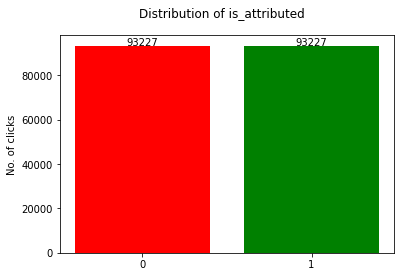

In [27]:
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, train['is_attributed'].value_counts(), color = ('red','green'))

for index, value in enumerate(train['is_attributed'].value_counts()):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

### 2. Time of Day for Clicks (in hour)

Extract day, hour, minute, second from click_time

In [62]:
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime
train['day'] = train_datetime.dt.day
train['hour'] = train_datetime.dt.hour
train['minute'] = train_datetime.dt.minute
train['second'] = train_datetime.dt.second

print(train.head())

       ip  app  device  os  channel          click_time  is_attributed  day  \
0  116992   15       1  34      245 2017-11-07 06:18:26              0    7   
1   92610    3       1  13      280 2017-11-07 03:06:29              0    7   
2   79894    2       1  19      122 2017-11-07 11:15:24              0    7   
3   32746    3       1  31      480 2017-11-08 14:44:58              0    8   
4    1638    2       1  20      236 2017-11-09 10:24:38              0    9   

   hour  minute  second  
0     6      18      26  
1     3       6      29  
2    11      15      24  
3    14      44      58  
4    10      24      38  


In [29]:
train_hour_0 = train[train["is_attributed"] == 0]['hour']
train_hour_1 = train[train["is_attributed"] == 1]['hour']

train_min_0 = train[train["is_attributed"] == 0]['minute']
train_min_1 = train[train["is_attributed"] == 1]['minute']

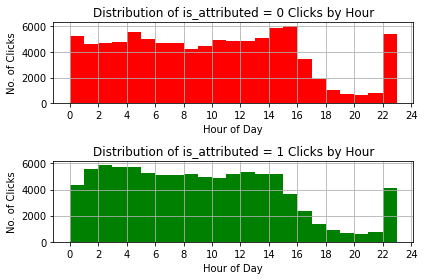

In [30]:
hours = 24 # 24 hours in a day

# Histogram for fraud clicks
plt.subplot(2, 1, 1)
train_hour_0.hist(bins = hours - 1, color = "red")
plt.xlabel("Hour of Day")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 0 Clicks by Hour")
plt.locator_params(axis = "x", nbins = hours)

# Histogram for normal clicks
plt.subplot(2, 1, 2)
train_hour_1.hist(bins = hours - 1, color = "green")
plt.xlabel("Hour of Day")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 1 Clicks by Hour")
plt.locator_params(axis = "x", nbins = hours)

plt.tight_layout()
plt.show()

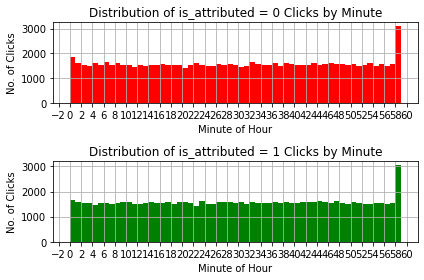

In [31]:
minutes = 60 # 60 minutes in an hour

# Histogram for fraud clicks
plt.subplot(2, 1, 1)
train_min_0.hist(bins = minutes - 1, color = "red")
plt.xlabel("Minute of Hour")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 0 Clicks by Minute")
plt.locator_params(axis = "x", nbins = minutes)

# Histogram for normal clicks
plt.subplot(2, 1, 2)
train_min_1.hist(bins = minutes - 1, color = "green")
plt.xlabel("Minute of Hour")
plt.ylabel("No. of Clicks")
plt.title("Distribution of is_attributed = 1 Clicks by Minute")
plt.locator_params(axis = "x", nbins = minutes)

plt.tight_layout()
plt.show()

### 3. Average Number of Clicks

In [32]:
train_0 = train[train["is_attributed"] == 0]
train_1 = train[train["is_attributed"] == 1]

num_ip_0 = train_0['ip'].nunique()
num_ip_1 = train_1['ip'].nunique()

num_app_0 = train_0['app'].nunique()
num_app_1 = train_1['app'].nunique()

num_clicks_0 = train_0.size
num_clicks_1 = train_1.size

avg_clicks_ip_0 = num_clicks_0 / num_ip_0
avg_clicks_ip_1 = num_clicks_1 / num_ip_1

avg_clicks_app_0 = num_clicks_0 / num_app_0
avg_clicks_app_1 = num_clicks_1 / num_app_1

print(num_ip_0, num_ip_1)
print(num_app_0, num_app_1)

33418 67422
165 174


<BarContainer object of 2 artists>

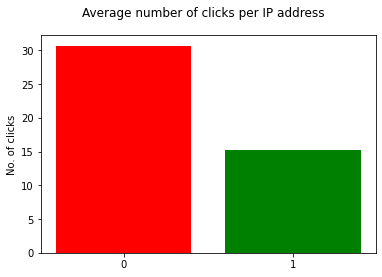

In [33]:
fig, ax = plt.subplots()
fig.suptitle('Average number of clicks per IP address')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, (avg_clicks_ip_0, avg_clicks_ip_1), color = ('red','green'))

Great difference between the two classes

<BarContainer object of 2 artists>

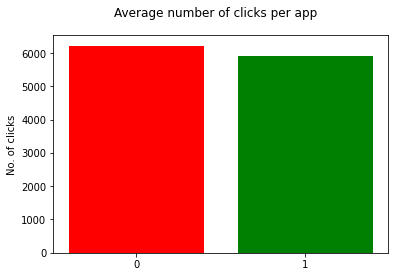

In [34]:
fig, ax = plt.subplots()
fig.suptitle('Average number of clicks per app')
labels = ['0', '1']

ax.set_ylabel('No. of clicks')
ax.bar(labels, (avg_clicks_app_0, avg_clicks_app_1), color = ('red','green'))

### 4. Distribution of Device


In [35]:
fraud_data = train[train["is_attributed"] == 0]
notfraud_data = train[train["is_attributed"] == 1]

In [36]:
device_labels = sorted(train["device"].unique().tolist())
device_fraud = []
device_notfraud = []

for device in device_labels:
  device_fraud.append(len(fraud_data[fraud_data["device"] == device]))
  device_notfraud.append(len(notfraud_data[notfraud_data["device"] == device]))

device_labels = [str(x) for x in device_labels]

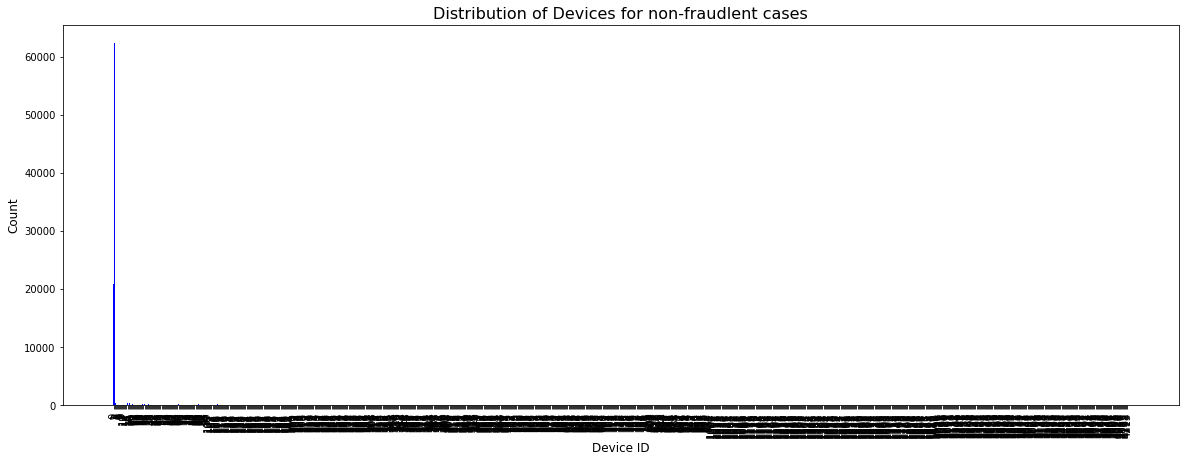

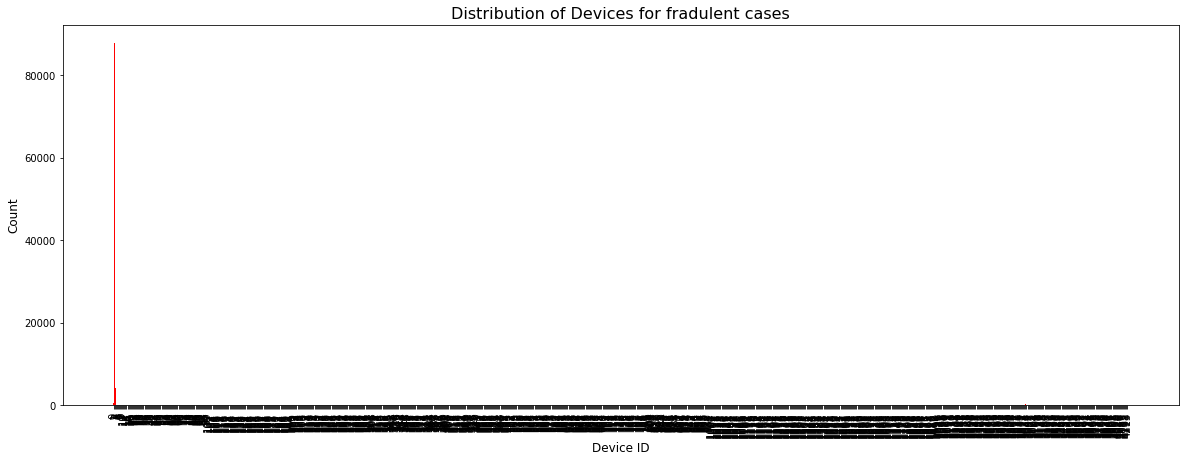

In [37]:
# Not fradulent
plt.figure(figsize = (20, 7))
plt.bar(x = device_labels,
        height = device_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of Devices for non-fraudlent cases", fontsize = 16) 
plt.xlabel("Device ID", fontsize = 12)

  # Option 1: Using normal scale  
plt.ylabel("Count", fontsize = 12)

  # Option 2: Using log scale
# plt.yscale('log')
# plt.ylabel("Log of Count", fontsize = 12)

plt.show()


# Fradulent
plt.figure(figsize = (20, 7))
plt.bar(x = device_labels,
        height = device_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of Devices for fradulent cases", fontsize = 16) 
plt.xlabel("Device ID", fontsize = 12)

  # Option 1: Using normal scale 
plt.ylabel("Count", fontsize = 12)

  # Option 2: Using log scale
# plt.yscale('log')
# plt.ylabel("Log of Count", fontsize = 12)

plt.show()

### 5. Distribution of Channel

In [39]:
channel_labels = sorted(train["channel"].unique().tolist())
channel_fraud = []
channel_notfraud = []

for channel in channel_labels:
  channel_fraud.append(len(fraud_data[fraud_data["channel"] == channel]))
  channel_notfraud.append(len(notfraud_data[notfraud_data["channel"] == channel]))

channel_labels = [str(x) for x in channel_labels]

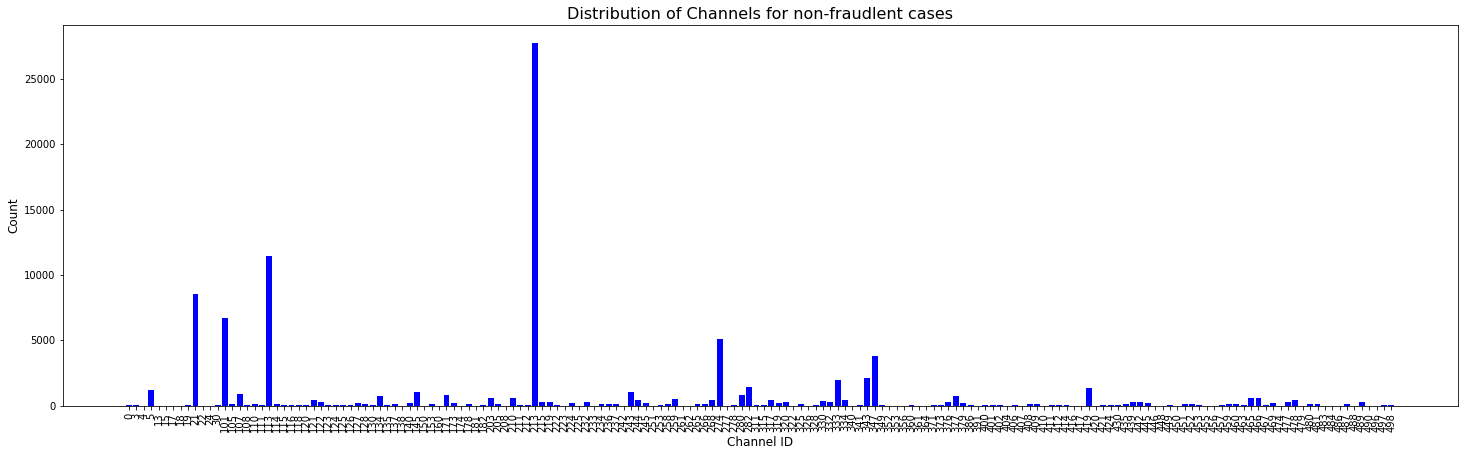

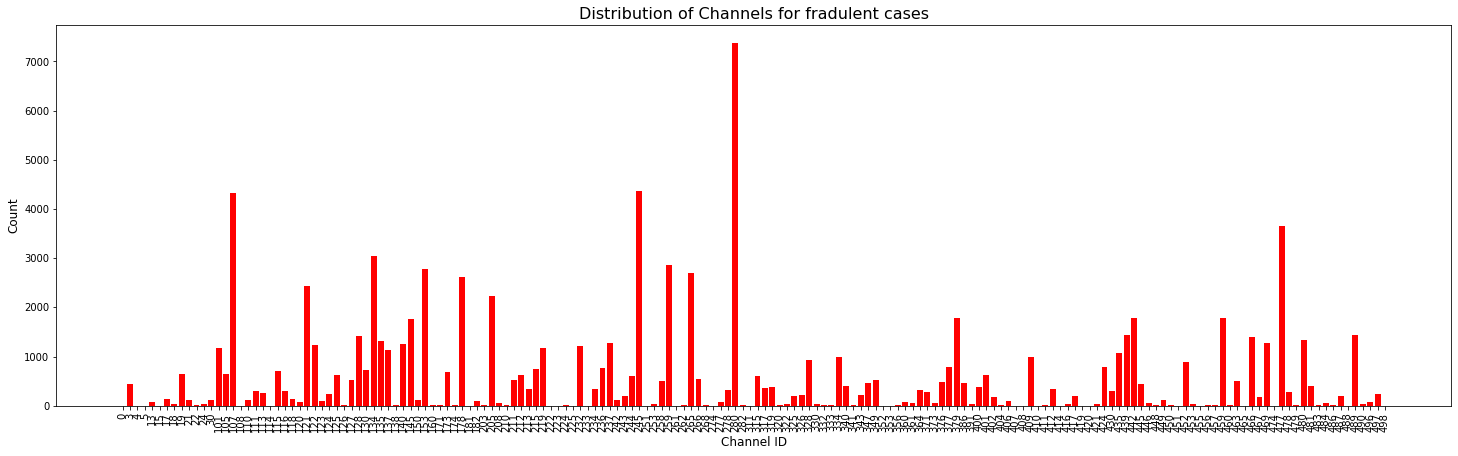

In [40]:
# Not fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = channel_labels,
        height = channel_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of Channels for non-fraudlent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = channel_labels,
        height = channel_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of Channels for fradulent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

### 6. Distribution of IP

In [42]:
ip_labels = sorted(train["ip"].unique().tolist())
ip_fraud = []
ip_notfraud = []

for ip in ip_labels:
  ip_fraud.append(len(fraud_data[fraud_data["ip"] == ip]))
  ip_notfraud.append(len(notfraud_data[notfraud_data["ip"] == ip]))

ip_labels = [str(x) for x in ip_labels]

In [ ]:
# Not fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = ip_labels,
        height = ip_notfraud,
        color = "blue")
plt.xticks(rotation = 90)
plt.title("Distribution of IP addresses for non-fraudlent cases", fontsize = 16) 
plt.xlabel("IP Adress", fontsize = 12)
plt.ylabel("Count", fontsize = 12)
plt.show()

# Fradulent
plt.figure(figsize = (25, 7))
plt.bar(x = ip_labels,
        height = ip_fraud,
        color = 'red')
plt.xticks(rotation = 90)
plt.title("Distribution of IP addresses for fradulent cases", fontsize = 16) 
plt.xlabel("Channel ID", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

plt.show()

In [ ]:
# For checks
print("IP Labels are: ", "\n", ip_labels)
print("Non fradulent counts are: ", "\n", ip_fraud)
print("Fradulent counts are: ", "\n", ip_notfraud)

### 7. Distribution of OS

In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.countplot(x="os", hue="is_attributed", data=train)
ax.set_yscale("log")
ax.legend(loc="upper right")
# generate graph xlabels
attributed_os = train[train["is_attributed"]==1]["os"].unique()
os_xlabels = [str(i) if i in attributed_os else "" for i in sorted(train["os"].unique())]
ax.set_xticklabels(os_xlabels, fontsize=8)
ax.set_title("Distribution of OS")
plt.show()

### 8. Average Time between Clicks

In [5]:
from datetime import datetime

sorted_ip = sorted(train["ip"].unique())
sorted_ip_attributed = sorted(train[train["is_attributed"]==1]["ip"].unique())
click_average_time_0 = []
click_average_time_1 = []

def get_average_time(click_time):
  count = len(click_time)
  # assign -1 if click once
  if count <= 1:
    return -1
  else:
    start_time = datetime.strptime(click_time[0], '%Y-%m-%d %H:%M:%S')
    end_time = datetime.strptime(click_time[count-1], '%Y-%m-%d %H:%M:%S')
    difference = (end_time - start_time).total_seconds()/60
    if difference == 0:
      return 0
    else:
      return difference/(count-1)

for ip in sorted_ip:
  click_time = sorted(train[train["ip"]==ip]["click_time"].values)
  average_time = get_average_time(click_time)
  # remove -1 values for better visualization
  if average_time != -1:
    if ip in sorted_ip_attributed:
      click_average_time_1.append(average_time)
    else:
      click_average_time_0.append(average_time)


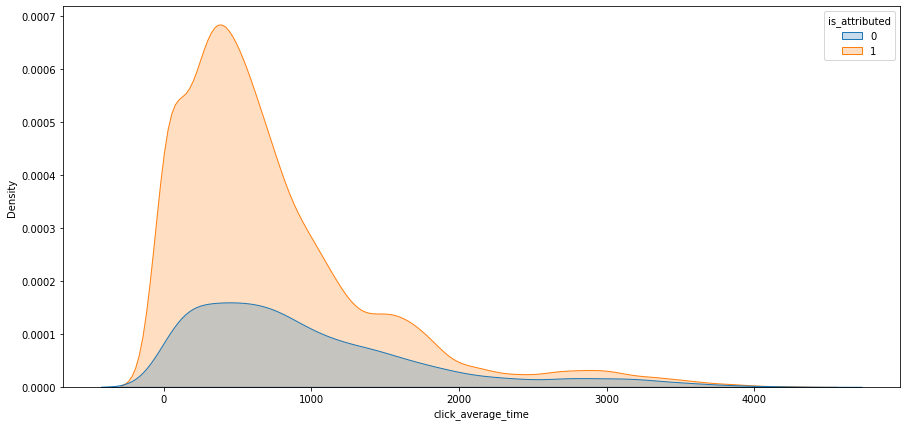

In [22]:
click_average = pd.DataFrame({'click_average_time': click_average_time_0 + click_average_time_1,
                              'is_attributed': [0] * len(click_average_time_0) + [1] * len(click_average_time_1)
                             })
plt.figure(figsize=(15, 7))
sns.kdeplot(data=click_average, x='click_average_time', hue="is_attributed", fill=True)
plt.show()

### 10. Conversion Rate between clicky IP and non clicky IP

In [23]:
#work with categorical varibles
categorical = train[["ip", "app", "device", "os", "channel", "is_attributed"]].apply(lambda x: x.astype("category"))
categorical.is_attributed = categorical.is_attributed.astype(int)
categorical.is_attributed.value_counts()

0    93227
1    93227
Name: is_attributed, dtype: int64

In [24]:
#each ip can have multiple clicks
train["ip"].value_counts()

5348      1122
5314      1109
73487      610
73516      589
53454      302
          ... 
318551       1
207538       1
45349        1
187707       1
5604         1
Name: ip, Length: 84781, dtype: int64

In [25]:
#conversion rate just by looking at ip
#can have multiple downloads per ip
agg_func_count = {"is_attributed": ["count", "sum"]}
x = train.groupby(["ip"]).agg(agg_func_count)
x.columns = ["clicks", "downloads"]
x = x.sort_values('clicks', ascending=False).reset_index()
x["conversion_rate"] = x.downloads/x.clicks
x.head()

,ip,clicks,downloads,conversion_rate
0,5348,1122,492,0.438503
1,5314,1109,481,0.433724
2,73487,610,239,0.391803
3,73516,589,204,0.346350
4,53454,302,29,0.096026


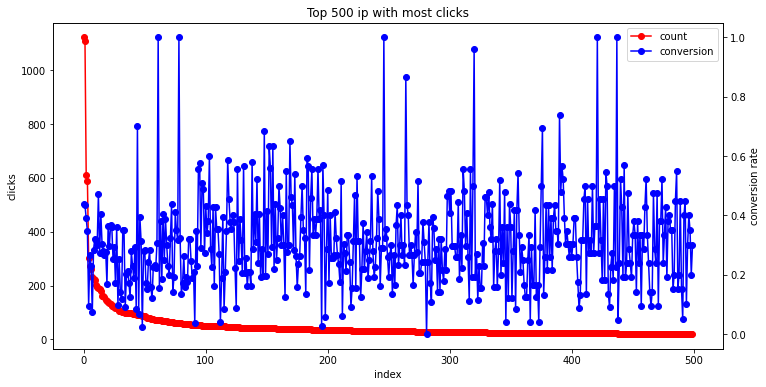

In [26]:
#comparing clicks and conversion rate for top 500 ip addresses
#whether there is download seem pretty random, does not really seem to be related to ip
fig,ax = plt.subplots(figsize=(12,6))

l1 = ax.plot(x.clicks[:500], color="red", marker="o", label="count")
ax.set_ylabel("clicks")

ax2=ax.twinx()
l2 = ax2.plot(x.conversion_rate[:500], color="blue", marker="o", label="conversion")
ax2.set_ylabel("conversion rate")

lns = l1+l2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")
ax.set_xlabel("index")
ax.set_title("Top 500 ip with most clicks")
plt.show()

### 11. Channel and Conversion Rate

In [29]:
train['click_date'] = train_datetime.dt.date
train['dateTime'] = pd.to_datetime(train.click_date) + pd.to_timedelta(train.hour, unit='h')
train_isAttributed = train[train['is_attributed'] == 1]

In [30]:
number_click_channel = pd.DataFrame(train.groupby(by=["channel"]).size()).reset_index()
number_click_channel = number_click_channel.rename({0: 'count'}, axis=1)
number_click_channel.rename(columns={'count':'number_click'}, inplace=True)

number_download_channel = pd.DataFrame(train_isAttributed.groupby(by=["channel"]).size()).reset_index()
number_download_channel = number_download_channel.rename({0: 'count'}, axis=1)
number_download_channel.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_channel = number_click_channel.join(number_download_channel.set_index('channel'), on="channel")
conversion_rate_channel['number_download'] = conversion_rate_channel['number_download'].fillna(0)
conversion_rate_channel['conversion_rate'] = conversion_rate_channel['number_download']/conversion_rate_channel['number_click']

In [31]:
conversion_rate_channel.head(5)

,channel,number_click,number_download,conversion_rate
0,0,32,31.0,0.968750
1,3,523,78.0,0.149140
2,4,12,12.0,1.000000
3,5,1166,1164.0,0.998285
4,13,83,3.0,0.036145


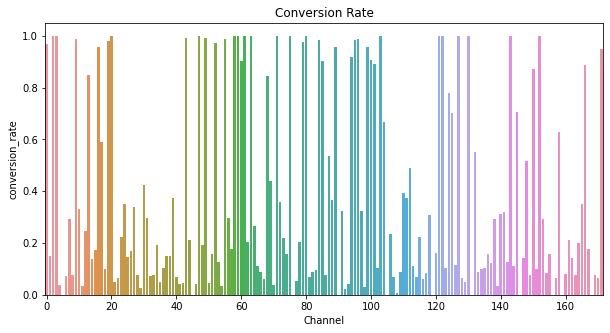

In [32]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=conversion_rate_channel, x='channel', y='conversion_rate')
ax.set_xlabel("Channel")
ax.set_title("Conversion Rate")
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

### 12. Device and Conversion Rate

In [33]:
number_click_device = pd.DataFrame(train.groupby(by=["device"]).size()).reset_index()
number_click_device = number_click_device.rename({0: 'count'}, axis=1)
number_click_device.rename(columns={'count':'number_click'}, inplace=True)

number_download_device = pd.DataFrame(train_isAttributed.groupby(by=["device"]).size()).reset_index()
number_download_device = number_download_device.rename({0: 'count'}, axis=1)
number_download_device.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_device = number_click_device.join(number_download_device.set_index('device'), on="device")
conversion_rate_device['number_download'] = conversion_rate_device['number_download'].fillna(0)
conversion_rate_device['conversion_rate'] = conversion_rate_device['number_download']/conversion_rate_device['number_click']

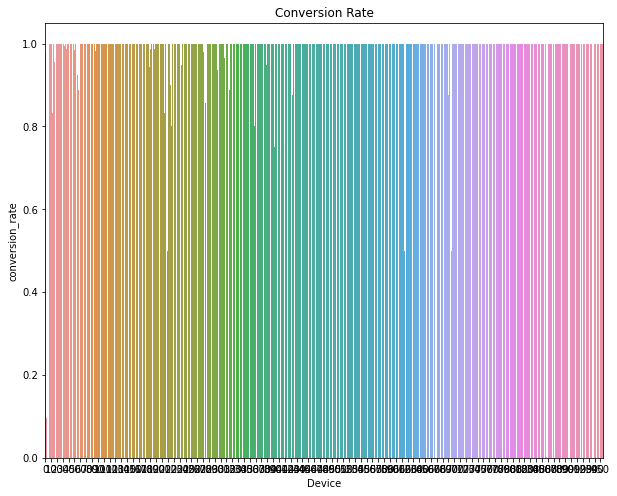

In [34]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data=conversion_rate_device, x='device', y='conversion_rate')
ax.set_xlabel("Device")
ax.set_title("Conversion Rate")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

### 13. Click and Conversion Rate throughout the day

In [35]:
number_click_time = pd.DataFrame(train.groupby(by=["dateTime"]).size()).reset_index()
number_click_time = number_click_time.rename({0: 'count'}, axis=1)
number_click_time.rename(columns={'count':'number_click'}, inplace=True)

number_download_time= pd.DataFrame(train_isAttributed.groupby(by=["dateTime"]).size()).reset_index()
number_download_time = number_download_time.rename({0: 'count'}, axis=1)
number_download_time.rename(columns={'count':'number_download'}, inplace=True)

conversion_rate_time = number_click_time.join(number_download_time.set_index('dateTime'), on="dateTime")
conversion_rate_time['number_download'] = conversion_rate_time['number_download'].fillna(0)
conversion_rate_time['conversion_rate'] = conversion_rate_time['number_download']/conversion_rate_time['number_click']
conversion_rate_time = conversion_rate_time.set_index('dateTime')

/var/folders/tz/3bpf14pn36z72d11bmhk0zp00000gn/T/ipykernel_2028/2274248138.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(conversion_rate_time.index, rotation=-80)


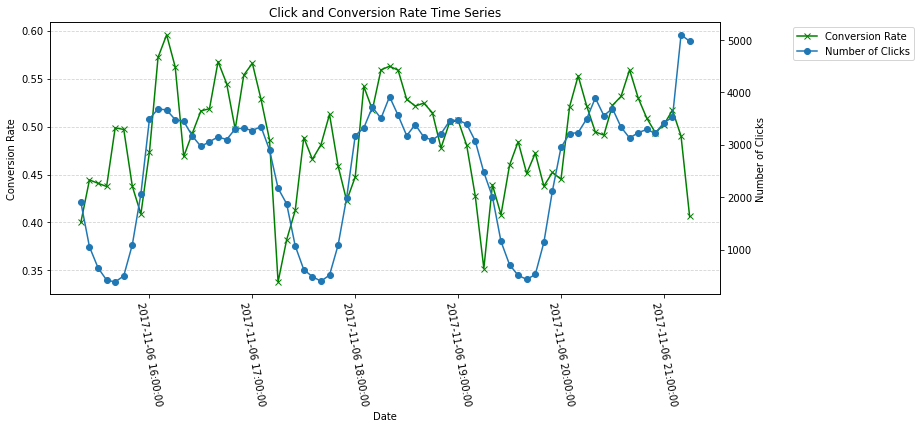

In [36]:
# setting figure size to 12, 10
fig, ax = plt.subplots(figsize=(12,5))
ax2 = ax.twinx()
# Labelling the axes and setting
# a title
ax.set_xlabel("Date")
ax.set_ylabel("Conversion Rate")
ax2.set_ylabel("Number of Clicks")
ax.set_title("Click and Conversion Rate Time Series")

# plotting the "A" column alone
p1, = ax.plot(conversion_rate_time['conversion_rate'],  color='green', marker='x', label='Conversion Rate')
p2, = ax2.plot(conversion_rate_time['number_click'], marker='o', label="Number of Clicks")
ax.set_xticklabels(conversion_rate_time.index, rotation=-80)
plt.legend(handles=[p1,p2],bbox_to_anchor=(1.2, 1), loc='upper center')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
ax2.yaxis.grid(False)
plt.show()

#  Feature Engineering

### Different combination/aggregation of features

In [63]:
#functions to help aggregate and count

#total counts
def agg_counts(df, group_cols, name):
  grp = df.groupby(group_cols).size().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df


#unique counts
def agg_unique(df, group_cols, unique_col, name):
  grp = df.groupby(group_cols)[unique_col].nunique().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df


#cumulative counts
def agg_cum_count(df, group_cols, name):
  grp = df.groupby(group_cols).cumcount()
  df[name] = grp.values
  return df

#variance
def agg_var(df, group_cols, counted, name):
    grp = df.groupby(group_cols)[counted].var().rename(name).to_frame().reset_index()
    df = df.merge(grp, on=group_cols, how='left')
    return df

#mean
def agg_mean(df, group_cols, counted, name):
    grp = df.groupby(group_cols)[counted].mean().rename(name).to_frame().reset_index()
    df = df.merge(grp, on=group_cols, how='left')
    return df

In [64]:
#data to do combi on 
train_agg = train.copy()
train_agg["dayOfWeek"] = train_agg["click_time"].dt.weekday
train_agg.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,second,dayOfWeek
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,26,1
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,29,1
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,24,1
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,58,2
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,38,3


In [65]:
#try some combinations, to see if there is a relationship
#total counts
train_agg = agg_counts(train_agg, ["ip", "app", "device", "os", "channel"], 'ip_app_dev_os_cha_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "device", "os"], 'ip_app_dev_os_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "device"], 'ip_app_dev_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "os"], 'ip_app_os_counts')
train_agg = agg_counts(train_agg, ["ip", "app", "hour"], 'ip_app_hour_counts')
train_agg = agg_counts(train_agg, ["ip", "channel"], 'ip_channel_counts')
train_agg = agg_counts(train_agg, ["ip", "app"], 'ip_app_counts')
train_agg = agg_counts(train_agg, ["ip", "day"], 'ip_per_day')
train_agg = agg_counts(train_agg, ["ip"], "ip_counts")

In [66]:
#unique counts
train_agg = agg_unique(train_agg, ["ip"], "app", "uniq_app_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "device", "uniq_device_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "channel", "uniq_channel_per_ip")
train_agg = agg_unique(train_agg, ["ip"], "os", "uniq_os_per_ip")
train_agg = agg_unique(train_agg, ["ip", "device", "os"], "app", "uniq_app_per_ip_dev_os")
train_agg = agg_unique(train_agg, ["app"], "channel", "uniq_channel_per_app")
train_agg = agg_unique(train_agg, ["ip", "day"], "hour", "uniq_hour_per_ip_day")
train_agg = agg_unique(train_agg, ["ip", "app"], "os", "uniq_os_per_ip_app")

In [67]:
#cumulative counts
train_agg = agg_cum_count(train_agg, ["ip"], "cum_count_by_ip")
train_agg = agg_cum_count(train_agg, ["ip", "device"], "cum_count_by_ip_device")
train_agg = agg_cum_count(train_agg, ["ip", "device","os"], "cum_count_by_ip_device_os")
train_agg = agg_cum_count(train_agg, ["ip", "device","os","channel"], "cum_count_by_ip_device_os_channel")
train_agg = agg_cum_count(train_agg, ["ip", "device","os","channel","app"], "cum_count_by_ip_device_os_channel_app")
train_agg = agg_cum_count(train_agg, ["app"], "cum_count_by_app")
train_agg = agg_cum_count(train_agg, ["ip", "app"], "cum_count_by_ip_app")

In [68]:
#variance
train_agg = agg_var(train_agg, ["ip","app","channel"], "hour", "var_hour_by_ip_app_channel")
train_agg = agg_var(train_agg, ["ip","app","os"], "hour", "var_hour_by_ip_app_os")
train_agg = agg_var(train_agg, ["ip","app","device"], "hour", "var_hour_by_ip_app_device")
train_agg = agg_var(train_agg, ["ip","app","channel"], "dayOfWeek", "var_day_by_ip_app_channel")
train_agg = agg_var(train_agg, ["ip","app","os"], "dayOfWeek", "var_day_by_ip_app_os")
train_agg = agg_var(train_agg, ["ip","app","device"], "dayOfWeek", "var_day_by_ip_app_device")

In [69]:
#mean
train_agg = agg_mean(train_agg, ["ip","app","channel"], "hour", "mean_hour_by_ip_app_channel")
train_agg = agg_mean(train_agg, ["ip","app","os"], "hour", "mean_hour_by_ip_app_os")
train_agg = agg_mean(train_agg, ["ip","app","device"], "hour", "mean_hour_by_ip_app_device")

In [51]:
train = train_agg
train.head(5)

,ip,app,device,os,channel,click_time,is_attributed
0,116992,15,1,34,245,2017-11-07 06:18:26,0
1,92610,3,1,13,280,2017-11-07 03:06:29,0
2,79894,2,1,19,122,2017-11-07 11:15:24,0
3,32746,3,1,31,480,2017-11-08 14:44:58,0
4,1638,2,1,20,236,2017-11-09 10:24:38,0


In [70]:
#density plots get array of labels
xlab = np.array(train_agg.columns[14:len(train_agg.columns)])

def plot_rbyc(data_plot, xlab_arr, r, c, log = False):
  
  data = data_plot.copy()

  if log == True:
    data[xlab_arr] = np.log10(data_plot[xlab_arr])
    
  fig, axs = plt.subplots(r,c, figsize=(5*c, 2*r))
  row, col = 0, 0
    
  for i in range(0, len(xlab_arr)):
    sns.kdeplot(data=data, x=xlab_arr[i], hue="is_attributed", ax=axs[row,col], fill=True)
    if col == c-1:
      col = 0
      row += 1
    else:
      col +=1

  to_be_empty = r*c - len(xlab_arr)
  while to_be_empty > 0:
      axs[row,col].set_visible(False)
      if col == c-1:
        col = 0
        row += 1
      else:
        col +=1
      to_be_empty -= 1
      
  plt.tight_layout()
  plt.show()


Different combinations of aggregating original features: 



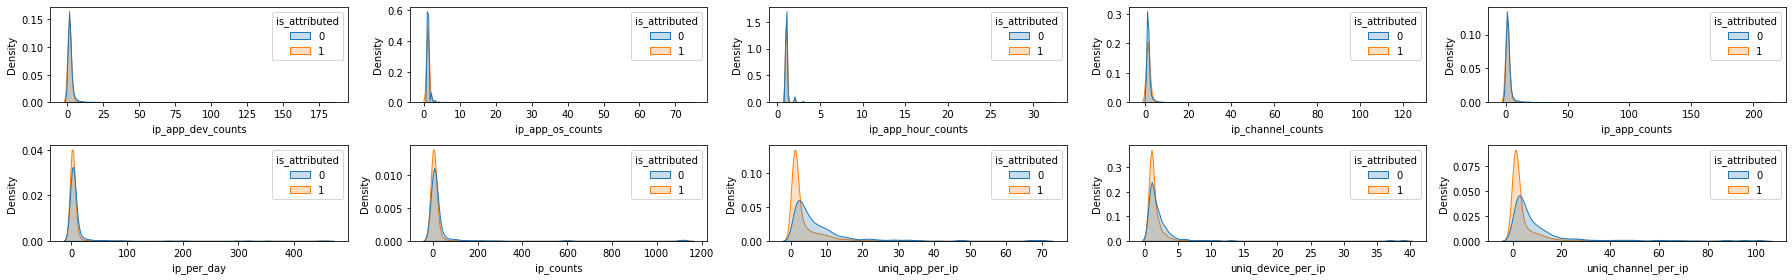

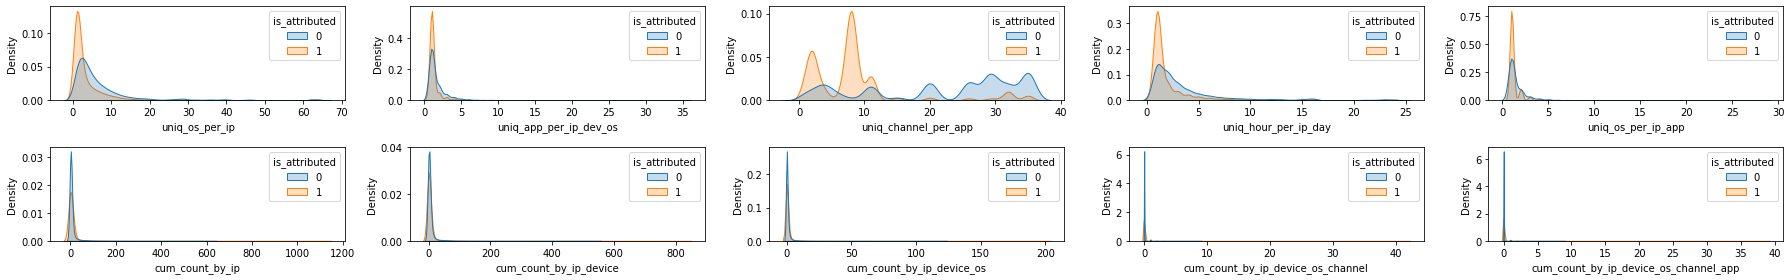

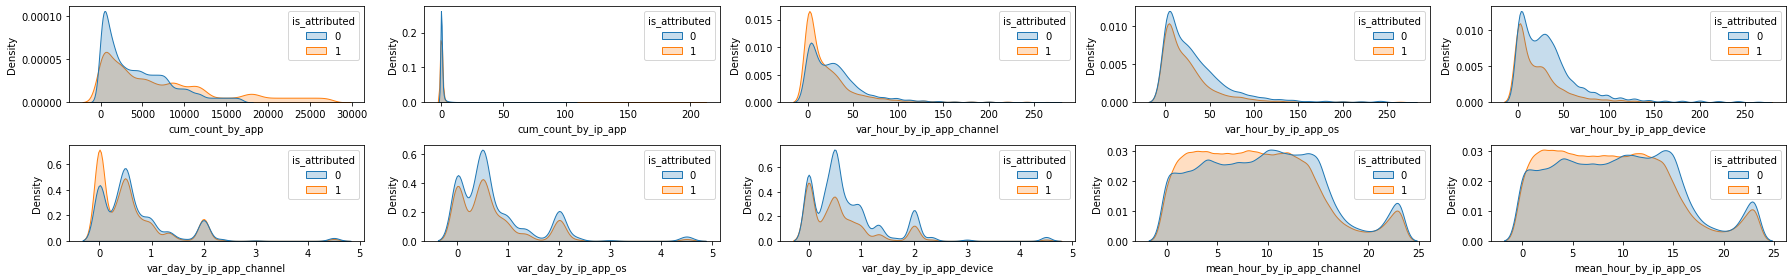

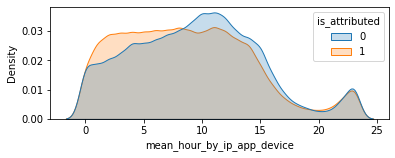

In [71]:
#plot all density plots -- 2 mins
r, c = 2, 5
total = r*c
print("Different combinations of aggregating original features: \n")
for i in range(0, len(xlab), total):
  x = xlab[i:i+total]
  plot_rbyc(train_agg, x, r, c)

## Time till next click

In [47]:
## Added from EDA
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime

GROUP_BY_NEXT_CLICKS = [
    
    # ip with one other feature
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'device']},
    {'groupby': ['ip', 'os']},
    {'groupby': ['ip', 'channel']},
    
    
    # ip with two other features
    {'groupby': ['ip', 'app', 'device']},
    {'groupby': ['ip', 'app', 'os']},
    {'groupby': ['ip', 'app', 'channel']},
    {'groupby': ['ip', 'device', 'os']},
    {'groupby': ['ip', 'device', 'channel']},
    {'groupby': ['ip', 'os', 'channel']},

    # ip with three other features
    {'groupby': ['ip', 'app', 'device', 'os']},
    {'groupby': ['ip', 'app', 'device', 'channel']},
    {'groupby': ['ip', 'device', 'os', 'channel']},

    # ip with all other features
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']}
]

# Calculate the time to next click for each group
for spec in GROUP_BY_NEXT_CLICKS:
    
    # Name of new feature
    new_feature = '{}_nextClick'.format('_'.join(spec['groupby']))    
    
    # Unique list of features to select
    all_features = spec['groupby'] + ['click_time']
    
    # Run calculation
    print(f">> Grouping by {spec['groupby']}, and saving time to next click in: {new_feature}")
    train[new_feature] = train[all_features].groupby(spec['groupby']).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    
train.head()

>> Grouping by ['ip'], and saving time to next click in: ip_nextClick
>> Grouping by ['ip', 'app'], and saving time to next click in: ip_app_nextClick
>> Grouping by ['ip', 'device'], and saving time to next click in: ip_device_nextClick
>> Grouping by ['ip', 'os'], and saving time to next click in: ip_os_nextClick
>> Grouping by ['ip', 'channel'], and saving time to next click in: ip_channel_nextClick
>> Grouping by ['ip', 'app', 'device'], and saving time to next click in: ip_app_device_nextClick
>> Grouping by ['ip', 'app', 'os'], and saving time to next click in: ip_app_os_nextClick
>> Grouping by ['ip', 'app', 'channel'], and saving time to next click in: ip_app_channel_nextClick
>> Grouping by ['ip', 'device', 'os'], and saving time to next click in: ip_device_os_nextClick
>> Grouping by ['ip', 'device', 'channel'], and saving time to next click in: ip_device_channel_nextClick
>> Grouping by ['ip', 'os', 'channel'], and saving time to next click in: ip_os_channel_nextClick
>> Gro

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,ip_app_device_nextClick,ip_app_os_nextClick,ip_app_channel_nextClick,ip_device_os_nextClick,ip_device_channel_nextClick,ip_os_channel_nextClick,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_device_os_channel_nextClick,ip_app_device_os_channel_nextClick
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,31022.0,NaN,59605.0,NaN,59605.0,NaN,NaN,59605.0,NaN,NaN
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,10969.0,10969.0,NaN,10969.0,NaN,NaN,10969.0,NaN,NaN,NaN
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,42475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,9224.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


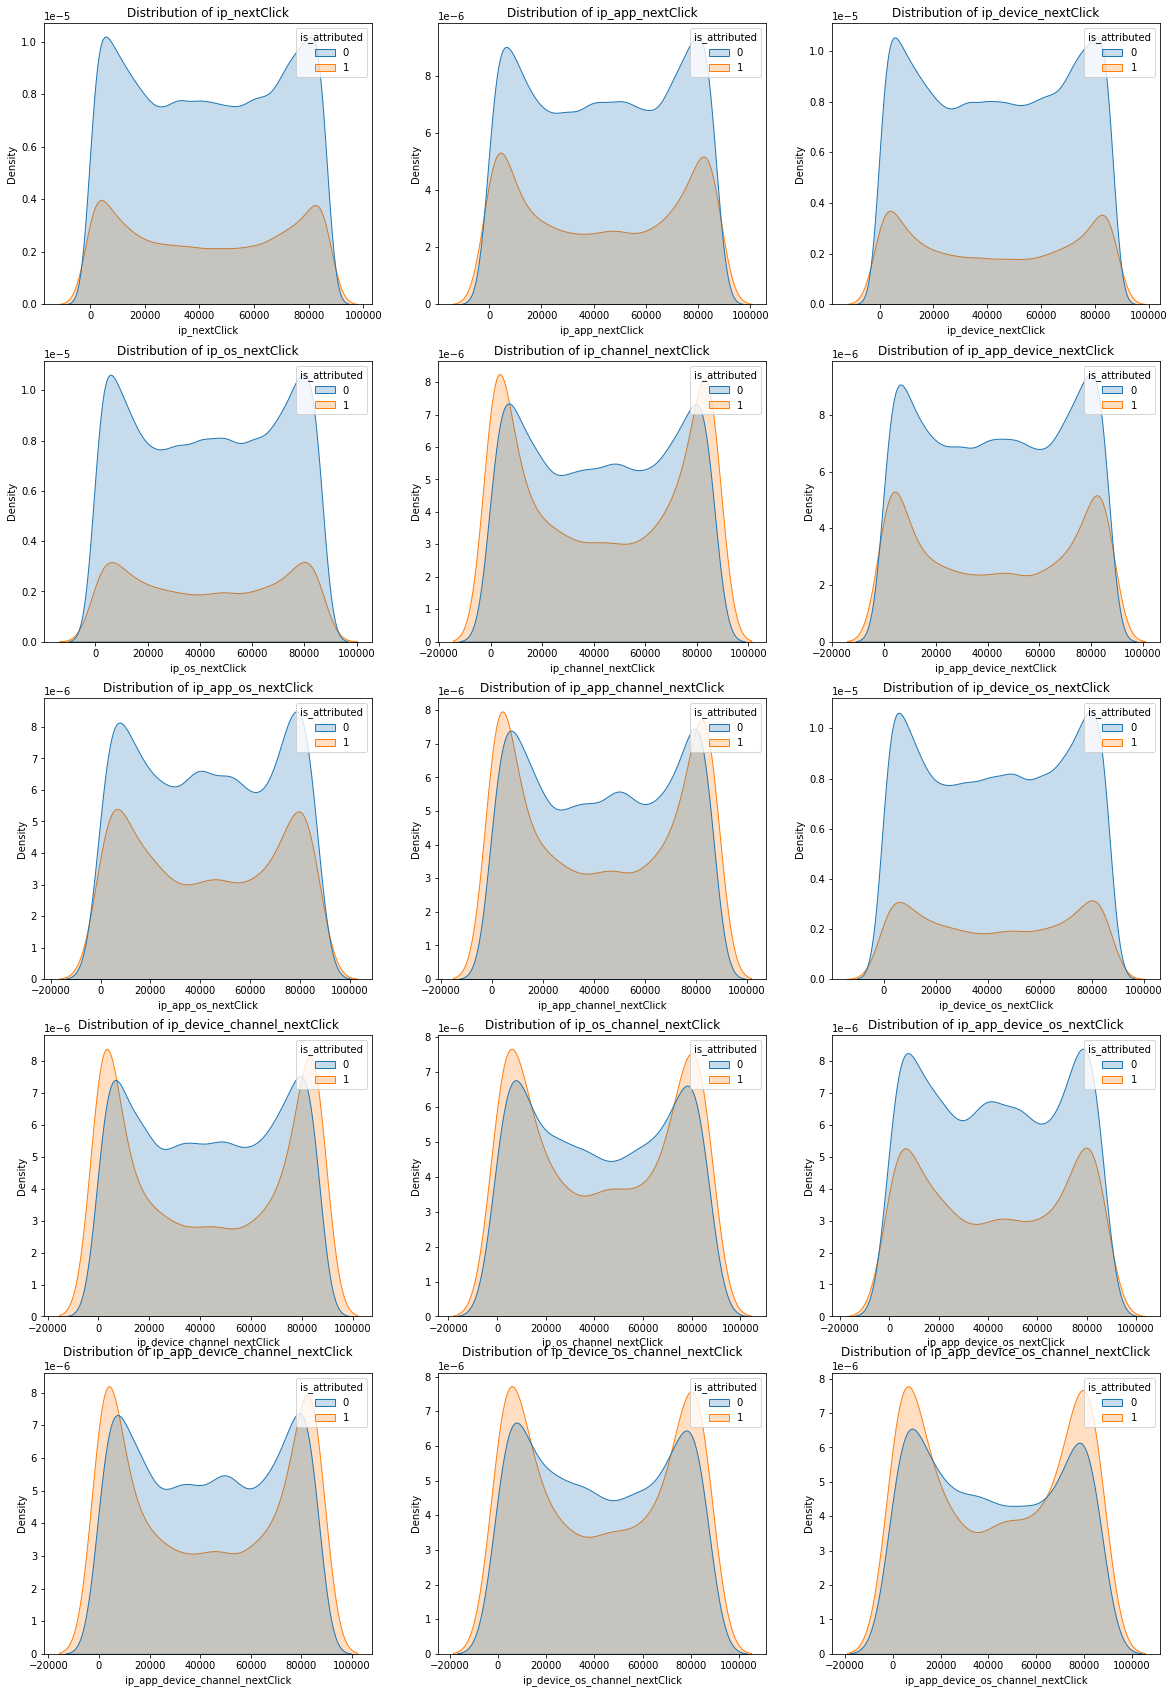

In [65]:
#density plots get array of labels

plt.figure(figsize=(20, 30))
for index, var in enumerate(train.columns[11:]):
  plt.subplot(5, 3, index+1)
  sns.kdeplot(data=train, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

In [ ]:
## for normal entries, they peak when the time btw clicks is ard 0s
## on the other hand for fraud entries, they when the time btw clicks is ard 0s and 80000s (ard 1 day)

215131

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BT4012/dataset/train_FE5.csv')

##  Clicks on app ad before & after

In [259]:
HISTORY_CLICKS = {
    'identical_clicks': ['ip', 'app', 'device', 'os', 'channel'],
    'app_clicks': ['ip', 'app']
}

# Go through different group-by combinations
for fname, fset in HISTORY_CLICKS.items():
    
    # Clicks in the past
    train['prev_'+fname] = train.groupby(fset).cumcount().rename('prev_'+fname)
        
    # Clicks in the future
    train['future_'+fname] = train.iloc[::-1].groupby(fset).cumcount().rename('future_'+fname).iloc[::-1]
 
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,ip_device_channel_nextClick,ip_os_channel_nextClick,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_device_os_channel_nextClick,ip_app_device_os_channel_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,59605.0,NaN,NaN,59605.0,NaN,NaN,0,0,0,3
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,NaN,NaN,10969.0,NaN,NaN,NaN,0,0,0,1
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1


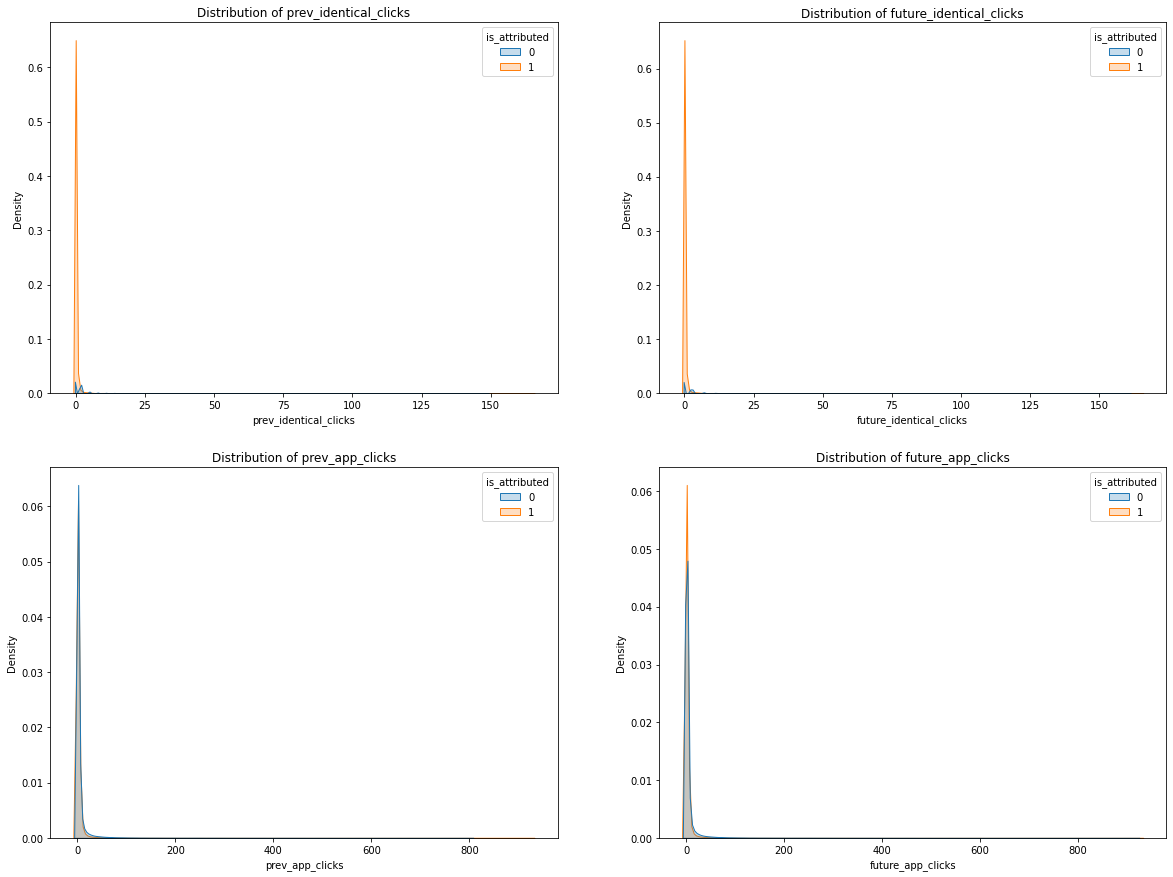

In [ ]:
plt.figure(figsize=(20, 15))
for index, var in enumerate(data.columns[26:30]):
  plt.subplot(2, 2, index+1)
  sns.kdeplot(data=data, x=var, hue="is_attributed", fill=True)
  plt.title(f"Distribution of {var}")

plt.show()

## Combining device & IP

In [263]:
train['device_ip'] = train['device'].map(str) + train['ip'].map(str)
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,device_confRate,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate,device_ip
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,0.358049,0.155254,0.022429,0.025245,0.000000,0.053586,0.000000,0.023461,0.157936,1116992
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,0.358049,0.288087,0.063045,0.053648,0.059310,0.077493,0.051676,0.064268,0.292719,192610
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,0.358049,0.322458,0.090301,0.059503,0.069368,0.068332,0.091254,0.093129,0.325176,179894
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,0.358049,0.156693,0.042289,0.039638,0.017383,0.077493,0.000000,0.042177,0.158367,132746
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,0.358049,0.199521,0.054623,0.054623,0.022488,0.068332,0.011217,0.054977,0.204446,11638


In [264]:
device_ip_1 = train[train['is_attributed'] == 1]['device_ip']
device_ip_0 = train[train['is_attributed'] == 0]['device_ip']

set_device_ip_1 = set(device_ip_1.unique())
set_device_ip_0 = set(device_ip_0.unique())

print('No. of unique device_ip that downloaded app:', len(set_device_ip_1))
print('No. of unique device_ip that did not download app:', len(set_device_ip_0))

No. of unique device_ip that downloaded app: 72740
No. of unique device_ip that did not download app: 35883


In [265]:
# device_ip that always download app after clicking
device_ip_download = set_device_ip_1.difference(set_device_ip_0)

# device_ip that always do not download app after clicking
device_ip_fraud = set_device_ip_0.difference(set_device_ip_1)

print('No. of device_ip that ALWAYS downloaded app:', len(device_ip_download))
print('No. of device_ip that NEVER downloaded app:', len(device_ip_fraud))

No. of device_ip that ALWAYS downloaded app: 59913
No. of device_ip that NEVER downloaded app: 23056


In [266]:
pct_device_ip_download = (len(device_ip_download) / len(set_device_ip_1))*100
pct_device_ip_fraud = (len(device_ip_fraud) / len(set_device_ip_0))*100

print('Percentage of device_ip that ALWAYS downloaded app:', round(pct_device_ip_download, 2), '%')
print('Percentage of device_ip that NEVER downloaded app:', round(pct_device_ip_fraud, 2), '%')

Percentage of device_ip that ALWAYS downloaded app: 82.37 %
Percentage of device_ip that NEVER downloaded app: 64.25 %


## Combining device & hour

In [267]:
train_hour_0 = train[train["is_attributed"] == 0]['hour']
train_hour_1 = train[train["is_attributed"] == 1]['hour']

In [268]:
train['device_hour'] = train['device'].map(str) + train['hour'].map(str)
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,os_confRate,channel_confRate,app_channel_confRate,app_os_confRate,app_device_confRate,channel_os_confRate,channel_device_confRate,os_device_confRate,device_ip,device_hour
0,116992,15,1,34,245,2017-11-07 06:18:26,0,7,6,18,...,0.155254,0.022429,0.025245,0.000000,0.053586,0.000000,0.023461,0.157936,1116992,16
1,92610,3,1,13,280,2017-11-07 03:06:29,0,7,3,6,...,0.288087,0.063045,0.053648,0.059310,0.077493,0.051676,0.064268,0.292719,192610,13
2,79894,2,1,19,122,2017-11-07 11:15:24,0,7,11,15,...,0.322458,0.090301,0.059503,0.069368,0.068332,0.091254,0.093129,0.325176,179894,111
3,32746,3,1,31,480,2017-11-08 14:44:58,0,8,14,44,...,0.156693,0.042289,0.039638,0.017383,0.077493,0.000000,0.042177,0.158367,132746,114
4,1638,2,1,20,236,2017-11-09 10:24:38,0,9,10,24,...,0.199521,0.054623,0.054623,0.022488,0.068332,0.011217,0.054977,0.204446,11638,110


In [269]:
device_hour_1 = train[train['is_attributed'] == 1]['device_hour']
device_hour_0 = train[train['is_attributed'] == 0]['device_hour']

set_device_hour_1 = set(device_hour_1.unique())
set_device_hour_0 = set(device_hour_0.unique())

print('No. of unique device_hour that downloaded app:', len(set_device_hour_1))
print('No. of unique device_hour that did not download app:', len(set_device_hour_0))

No. of unique device_hour that downloaded app: 3834
No. of unique device_hour that did not download app: 259


In [270]:
# device_hour that always download app after clicking
device_hour_download = set_device_hour_1.difference(set_device_hour_0)

# device_hour that always do not download app after clicking
device_hour_fraud = set_device_hour_0.difference(set_device_hour_1)

print('No. of device_hour that ALWAYS downloaded app:', len(device_hour_download))
print('No. of device_hour that NEVER downloaded app:', len(device_hour_fraud))

No. of device_hour that ALWAYS downloaded app: 3684
No. of device_hour that NEVER downloaded app: 109


In [271]:
pct_device_hour_download = (len(device_hour_download) / len(set_device_hour_1))*100
pct_device_hour_fraud = (len(device_hour_fraud) / len(set_device_hour_0))*100

print('Percentage of device_hour that ALWAYS downloaded app:', round(pct_device_hour_download, 2), '%')
print('Percentage of device_hour that NEVER downloaded app:', round(pct_device_hour_fraud, 2), '%')

Percentage of device_hour that ALWAYS downloaded app: 96.09 %
Percentage of device_hour that NEVER downloaded app: 42.08 %


In [273]:
##save the generated features
train.to_csv('./train_FE5.csv', index=False)

## Response Coding for Categorical Variables

In [70]:
from tqdm import tqdm

# what is alpha
def get_feature_dict(alpha, feature, df):
  value_count = train[feature].value_counts()
  feature_dict = dict()
  value_count_items = value_count.items()

  class_0 = train['is_attributed'] == 0
  class_1 = train['is_attributed'] == 1

  for i, denominator in tqdm(value_count_items):
    b = train[feature] == i
    vec = []

    for k in range(2):
      if k == 0:
        cls_cnt = train.loc[class_0 & b]
      else:
        cls_cnt = train.loc[class_1 & b]
      
      vec.append((cls_cnt.shape[0] + 10*alpha)/ (denominator + 20*alpha))
    
    feature_dict[i] = vec
  
  return feature_dict



def get_feature(alpha, feature, df, feature_dict):
  value_count = train[feature].value_counts()
  value_count_keys = dict(value_count).keys()
  
  feature = []
  for index, row in tqdm(df.iterrows()):
    if row[feature] in value_count_keys:
      feature.append(feature_dict[row[feature]])
    
    else:
      feature.append([1/2, 1/2])
  
  return feature

# Data Processing after new features generated

<p>Drop click_date and dateTime since they are redundant information</p>

In [34]:
data = data.drop(['click_date', 'dateTime'], axis = 1)

Deal with NaN values

In [35]:
checkna = [data[var].isnull().sum() for var in data.columns]
na_df = pd.DataFrame({"Variable": data.columns, "Number of Missing Values": checkna})

In [36]:
na_df[na_df["Number of Missing Values"] > 0]

,Variable,Number of Missing Values
36,var_hour_by_ip_app_channel,157117
37,var_hour_by_ip_app_os,169616
38,var_hour_by_ip_app_device,136110
39,var_day_by_ip_app_channel,157117
40,var_day_by_ip_app_os,169616
41,var_day_by_ip_app_device,136110
45,ip_nextClick,84781
46,ip_app_nextClick,150549
47,ip_device_nextClick,95806
48,ip_os_nextClick,147780


Variables with the naming convention "var_variable_by_variablegroup" represent the variance of $variable$ among $variablegroup$. It has NaN values when there is only one value in $variablegroup$. To deal with such missing values, we can set the NaN values to be 0, meaning that there is no variance for $variable$ among $variablegroup$.

Variables with the naming convention "variablegroup_nextClick" represent the time till next click between items in $variablegroup$. It has NaN values when there is no click after the current one in the $variablegroup$. We can interpret such variables as has_nextClick * time_till_nextClick, where has_nextClick takes 0 when there is no next click and 1 otherwise. Therefore, we can then set the NaN values to be 0.

In [37]:
data.fillna(0, inplace=True)

In [38]:
checkna1 = [data[var].isnull().sum() for var in data.columns]
na_df1 = pd.DataFrame({"Variable": data.columns, "Number of Missing Values": checkna1})
len(na_df1[na_df1["Number of Missing Values"] > 0])

0

In [38]:
data = pd.read_csv("./train_FE_processed.csv")

In [40]:
data = data.drop(labels = ['channel_conversion_rate', 'device_conversion_rate',
       'dateTime_conversion_rate'], axis = 1)

In [42]:
data = data.drop(labels = ['ip_confRate', 'app_confRate', 'device_confRate', 'os_confRate',
       'channel_confRate', 'app_channel_confRate', 'app_os_confRate',
       'app_device_confRate', 'channel_os_confRate', 'channel_device_confRate',
       'os_device_confRate'], axis = 1)

In [50]:
##save the data after processing
data.to_csv('./train_FE_processed.csv', index=False)

# Categorical Encoding

In [2]:
import pandas as pd
#Import data
train = pd.read_csv("./train_FE_processed.csv")
train.head(3)

,ip,app,device,os,channel,is_attributed,day,hour,minute,second,...,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_device_os_channel_nextClick,ip_app_device_os_channel_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks,device_ip,device_hour
0,116992,15,1,34,245,0,7,6,18,26,...,0,59605,0,0,0,0,0,3,1116992,16
1,136145,12,1,22,245,0,7,6,10,42,...,0,0,0,0,0,0,0,0,1136145,16
2,32371,15,1,11,245,0,7,6,51,41,...,0,0,0,0,0,0,0,0,132371,16


The categorical features to be encoded includes **'ip', 'app', 'device', 'os', 'channel', 'device_ip', and 'device_hour'**. 

Since the number of unique categories is large for each of those categorical features, one-hot encoding is no longer suitable as using it will result in huge the feature space. 

We will be using **count encoding**, where each category in each categorical variable will be replaced by the count of that category. Currently, if the test set has a unknown never seen before categories, it is currently replaced by 0 so as not to throw error when transforming test set (need to research more how to better handle never seen before categories). 

In [3]:
import category_encoders as ce
categorical_features = ['ip', 'app', 'device', 'os', 'channel', 'device_ip', 'device_hour']
#normalize the counts here as the count seems too big which may affect gradient descent?
count_enc = ce.CountEncoder(cols=categorical_features, handle_unknown='value', normalize=True)
new_train_categories = count_enc.fit_transform(train[categorical_features])
new_train_categories.head()

,ip,app,device,os,channel,device_ip,device_hour
0,0.000054,0.046462,0.805866,0.001024,0.024338,0.000054,0.046859
1,0.000005,0.068113,0.805866,0.034421,0.024338,0.000005,0.046859
2,0.000016,0.046462,0.805866,0.010651,0.024338,0.000016,0.046859
3,0.000005,0.046462,0.805866,0.010651,0.024338,0.000005,0.046859
4,0.000016,0.046462,0.805866,0.006420,0.024338,0.000005,0.046859


In [4]:
#replace original columns with data
train[categorical_features] = new_train_categories
train.head()

,ip,app,device,os,channel,is_attributed,day,hour,minute,second,...,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_device_os_channel_nextClick,ip_app_device_os_channel_nextClick,prev_identical_clicks,future_identical_clicks,prev_app_clicks,future_app_clicks,device_ip,device_hour
0,0.000054,0.046462,0.805866,0.001024,0.024338,0,7,6,18,26,...,0,59605,0,0,0,0,0,3,0.000054,0.046859
1,0.000005,0.068113,0.805866,0.034421,0.024338,0,7,6,10,42,...,0,0,0,0,0,0,0,0,0.000005,0.046859
2,0.000016,0.046462,0.805866,0.010651,0.024338,0,7,6,51,41,...,0,0,0,0,0,0,0,0,0.000016,0.046859
3,0.000005,0.046462,0.805866,0.010651,0.024338,0,7,6,34,39,...,0,0,0,0,0,0,0,0,0.000005,0.046859
4,0.000016,0.046462,0.805866,0.006420,0.024338,0,7,6,33,56,...,0,0,0,0,0,0,0,0,0.000005,0.046859


In [16]:
#test set
#new_test_cat = count_enc.transform(test[categorical_features])

is_attributed        0        1
ip                             
0.000005       11157.0  48129.0
0.000011       11631.0   9401.0
0.000016        9507.0   5643.0
0.000021        7705.0   3843.0
0.000027        5827.0   2883.0
0.000032        4621.0   2207.0
0.000038        3409.0   1722.0
0.000043        2868.0      NaN
0.000048        2752.0      NaN
0.000054        2465.0      NaN
0.000059        2272.0      NaN
0.000064        2111.0      NaN
0.000070        2038.0      NaN


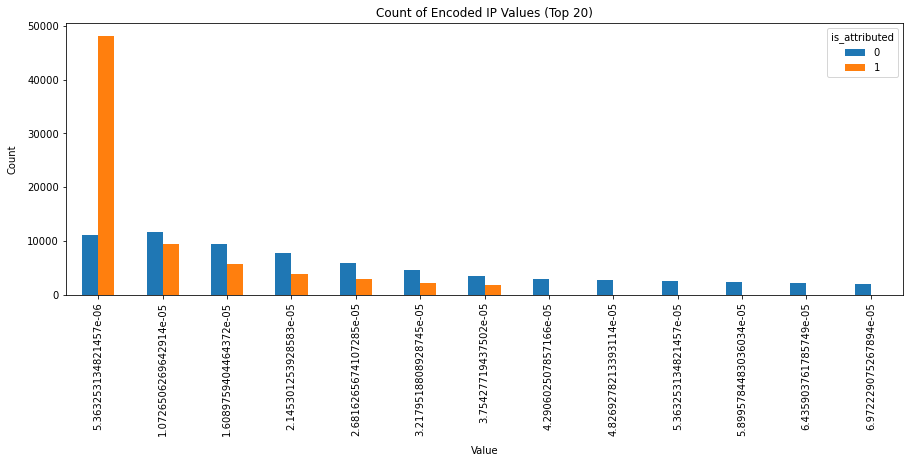

In [11]:
ip_encoded_value_counts = train.groupby(['ip']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(ip_encoded_value_counts)

ip_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded IP Values (Top 20)");

is_attributed        0        1
app                            
0.010550        1878.0      NaN
0.012512           NaN   2324.0
0.013097        2287.0      NaN
0.016846        1813.0      NaN
0.017189        2966.0      NaN
0.018240           NaN   3371.0
0.030034        5086.0      NaN
0.031477           NaN   5705.0
0.039093           NaN   6942.0
0.046462        7978.0      NaN
0.047052           NaN   8468.0
0.052136        8023.0      NaN
0.063839       10748.0      NaN
0.065609        8459.0   3774.0
0.068113       12174.0      NaN
0.068542           NaN  12768.0
0.101864       16961.0   2032.0
0.148573           NaN  27290.0


Text(0.5, 1.0, 'Count of Encoded App Values (Top 20)')

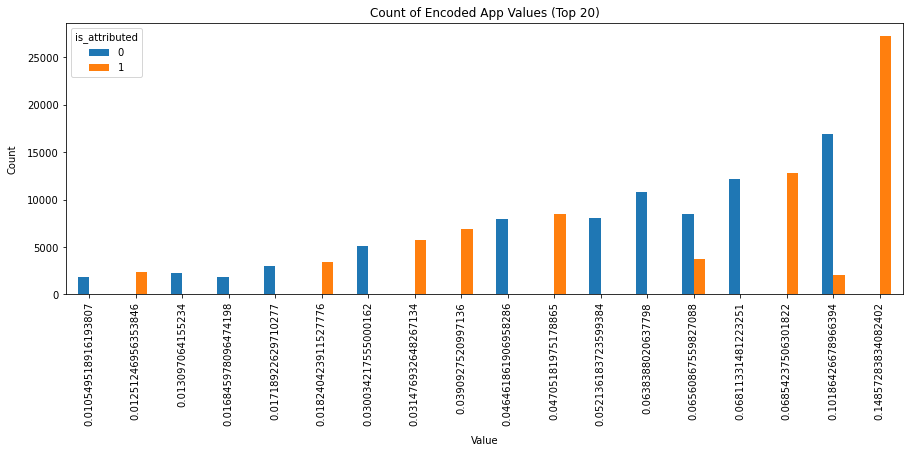

In [8]:
app_encoded_value_counts = train.groupby(['app']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(app_encoded_value_counts)

app_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded App Values (Top 20)")

is_attributed        0        1
device                         
0.000005           NaN    425.0
0.000011           NaN    221.0
0.000016           NaN    233.0
0.000021           NaN    199.0
0.000032           NaN    218.0
0.000038           NaN    173.0
0.000359           NaN    200.0
0.001217           NaN    223.0
0.001427           NaN    264.0
0.001727           NaN    320.0
0.001807         336.0      NaN
0.002408           NaN    447.0
0.003084           NaN    568.0
0.003529           NaN    654.0
0.024660        4160.0    438.0
0.114398         467.0  20863.0
0.805866       87903.0  62354.0


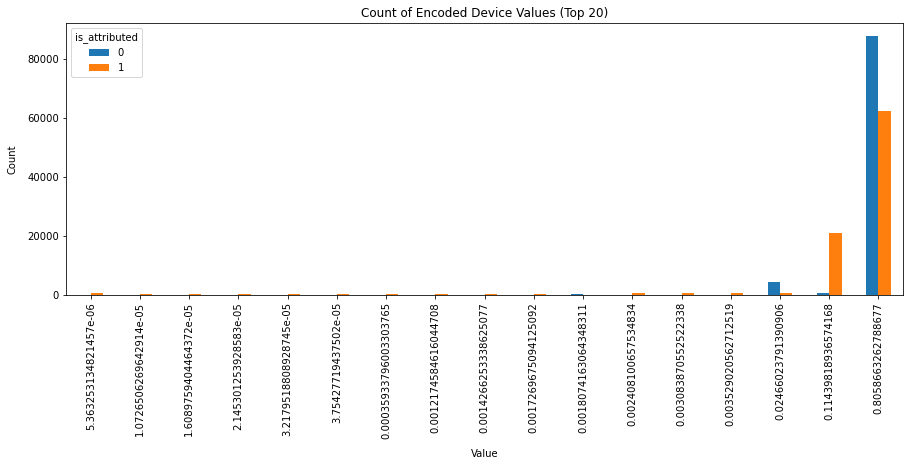

In [7]:
device_encoded_value_counts = train.groupby(['device']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(device_encoded_value_counts)

device_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Device Values (Top 20)")

is_attributed        0        1
os                             
0.013660           NaN   2467.0
0.015543        2267.0      NaN
0.016208        2163.0      NaN
0.018192        2281.0      NaN
0.020777        2730.0      NaN
0.021045           NaN   3885.0
0.021217        2645.0      NaN
0.022161           NaN   4084.0
0.034421        3823.0   2595.0
0.037023        4548.0   2355.0
0.039200        4974.0   2335.0
0.042606           NaN   7781.0
0.053627           NaN   9835.0
0.173936       20004.0  12427.0
0.206887       22302.0  16273.0


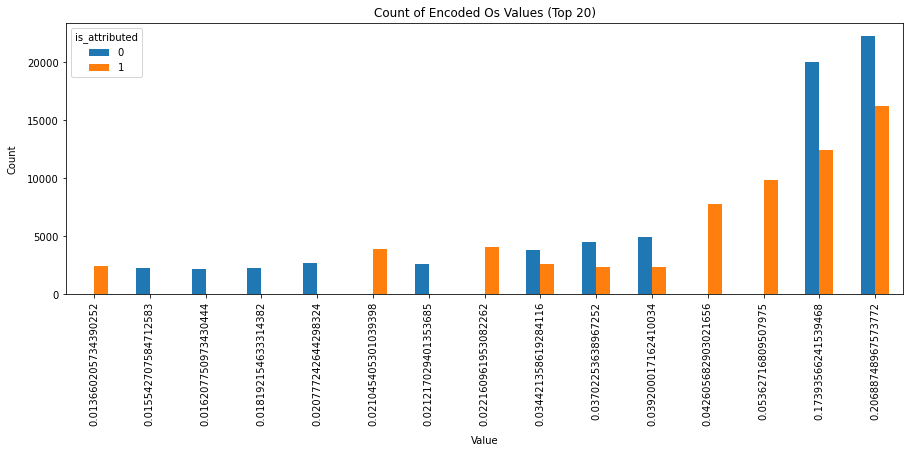

In [10]:
os_encoded_value_counts = train.groupby(['os']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(os_encoded_value_counts)

os_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Os Values (Top 20)");

is_attributed       0        1
channel                       
0.007825       2331.0      NaN
0.010491          NaN   1934.0
0.012512       2441.0   2225.0
0.014615       2615.0      NaN
0.015242       2690.0      NaN
0.015328       2441.0      NaN
0.015580       2779.0      NaN
0.018139       2852.0      NaN
0.020166       3038.0      NaN
0.021019       3663.0      NaN
0.022837          NaN   3801.0
0.024338       4371.0      NaN
0.027288          NaN   5085.0
0.028012       4320.0      NaN
0.042305          NaN   6712.0
0.043759       7370.0      NaN
0.046263          NaN   8511.0
0.062696          NaN  11441.0
0.150530          NaN  27724.0


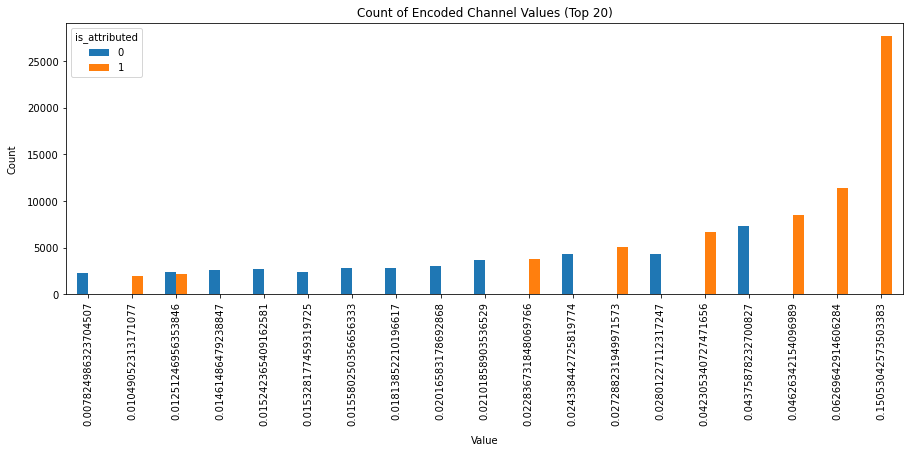

In [12]:
channel_encoded_value_counts = train.groupby(['channel']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(channel_encoded_value_counts)

channel_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Channel Values (Top 20)");

is_attributed        0        1
device_ip                      
0.000005       14637.0  55107.0
0.000011       12375.0   9201.0
0.000016        9788.0   4990.0
0.000021        7815.0   3253.0
0.000027        5809.0   2516.0
0.000032        4488.0   1860.0
0.000038        3570.0   1491.0
0.000043        3061.0      NaN
0.000048        2812.0      NaN
0.000054        2556.0      NaN
0.000059        2078.0      NaN
0.000064        1981.0      NaN
0.000070        1801.0      NaN


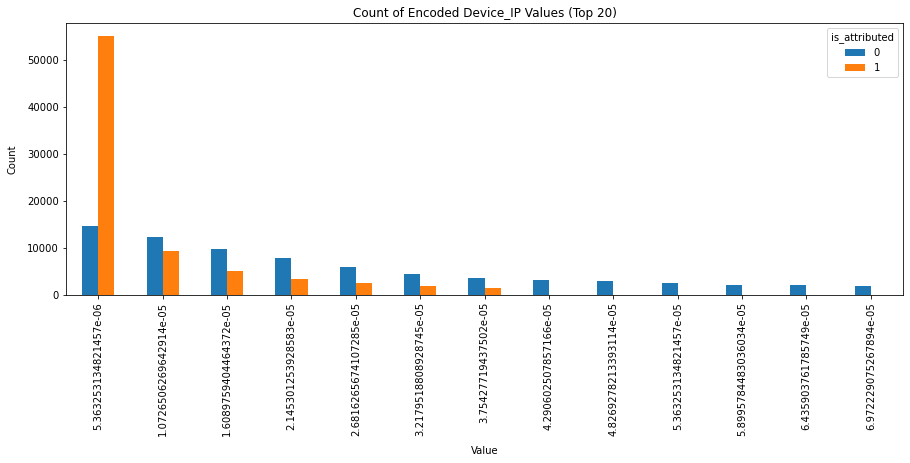

In [13]:
device_ip_encoded_value_counts = train.groupby(['device_ip']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(device_ip_encoded_value_counts)

device_ip_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Device_IP Values (Top 20)");

is_attributed       0       1
device_hour                  
0.040257       4637.0     NaN
0.040310       4350.0     NaN
0.040503       4387.0     NaN
0.040653       4592.0     NaN
0.041029       5581.0     NaN
0.044703       4474.0     NaN
0.044853       5420.0     NaN
0.046859       4529.0     NaN
0.051535       4812.0  4797.0
0.051825       5070.0  4593.0
0.054920       4496.0  5744.0
0.056421       4604.0  5916.0
0.056464       4608.0  5920.0
0.058229       5309.0  5548.0


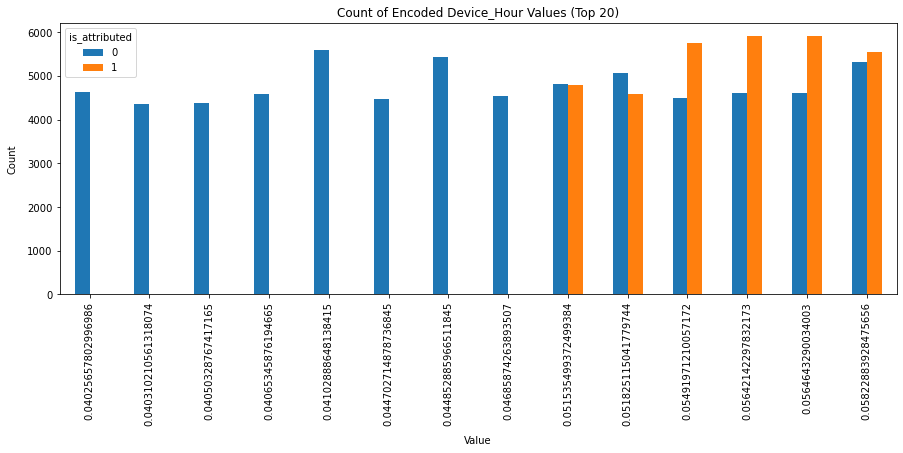

In [15]:
device_hour_encoded_value_counts = train.groupby(['device_hour']).is_attributed.value_counts().nlargest(20, keep='all').unstack()
print(device_hour_encoded_value_counts)

device_hour_encoded_value_counts.plot(kind='bar', figsize=(15, 5))
plt.xlabel("Value", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Count of Encoded Device_Hour Values (Top 20)");

### KNN

Default parameters & basic features

In [13]:
basic_features = ['ip', 'app', 'device', 'os', 'channel']
X_train_basic = X_train[basic_features]

In [25]:
#fit KNN classifier to the training set
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
knn.fit(X_train_basic, Y_train)
#predict the train set
y_pred = knn.predict(X_train_basic)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[89482  3745]
 [ 8418 84809]] 

Accuracy: 0.9347667521211667 

Precision: 0.957709420240757 

Recall: 0.909704270222146 

F1 Score: 0.9330898168675494


Default parameters & top 10 features

In [29]:
top_10_features = ['app', 'uniq_channel_per_ip', 'uniq_os_per_app',
       'uniq_channel_per_app', 'uniq_ip_per_app', 'device', 'ip',
       'uniq_app_per_ip', 'uniq_device_per_app', 'os',
       'uniq_app_per_channel', 'uniq_ip_per_channel',
       'uniq_device_per_channel', 'uniq_channel_per_ip_app',
       'uniq_app_per_os', 'uniq_hour_per_ip_day', 'channel',
       'uniq_app_per_ip_device_os', 'device_hour_counts',
       'uniq_os_per_channel'][:10]
X_train_top_10 = X_train[top_10_features]

In [30]:
#fit KNN classifier to the training set
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
knn.fit(X_train_top_10, Y_train)
#predict the train set
y_pred = knn.predict(X_train_top_10)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[89595  3632]
 [ 8221 85006]] 

Accuracy: 0.9364293605929612 

Precision: 0.959024346217198 

Recall: 0.9118173919572656 

F1 Score: 0.9348252824897588


Default parameters & top 20 features

In [27]:
top_features = ['app', 'uniq_channel_per_ip', 'uniq_os_per_app',
       'uniq_channel_per_app', 'uniq_ip_per_app', 'device', 'ip',
       'uniq_app_per_ip', 'uniq_device_per_app', 'os',
       'uniq_app_per_channel', 'uniq_ip_per_channel',
       'uniq_device_per_channel', 'uniq_channel_per_ip_app',
       'uniq_app_per_os', 'uniq_hour_per_ip_day', 'channel',
       'uniq_app_per_ip_device_os', 'device_hour_counts',
       'uniq_os_per_channel']
X_train_top = X_train[top_features]

In [28]:
#fit KNN classifier to the training set
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
knn.fit(X_train_top, Y_train)
#predict the train set
y_pred = knn.predict(X_train_top)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[89622  3605]
 [ 7853 85374]] 

Accuracy: 0.9385478455812157 

Precision: 0.9594848222614325 

Recall: 0.9157647462644942 

F1 Score: 0.9371151334204143


#### Tune KNN model

Basic features

In [43]:
estimator_KNN = KNeighborsClassifier(algorithm='auto') # ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.
parameters_KNN = {
    'n_neighbors': (1,10, 1), # Number of neighbors to use.
    'leaf_size': (20,40,1), # This can affect the speed of the construction and query, as well as the memory required to store the tree.
    'p': (1,2), # When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2.
    'weights': ('uniform', 'distance'), # 'uniform': uniform weights. All points in each neighborhood are weighted equally.
                                        #'distance': weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    'metric': ('minkowski', 'chebyshev')}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    cv = 5)

grid_search_KNN.fit(X_train_basic,Y_train)
print(grid_search_KNN.best_estimator_)
print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_score_)

KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1)
{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.9173254524857406


In [44]:
#fit KNN classifier to the training set
knn_best = KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, weights='uniform')  
knn_best.fit(X_train_basic, Y_train)
#predict the train set
y_pred = knn_best.predict(X_train_basic)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[90064  3163]
 [10542 82685]] 

Accuracy: 0.9264966157872719 

Precision: 0.9631558102693132 

Recall: 0.8869211709054244 

F1 Score: 0.9234678207454978


In [48]:
#fit KNN classifier to the training set
knn_best2 = KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=2, weights='distance')  
knn_best2.fit(X_train_basic, Y_train)
#predict the train set
y_pred = knn_best2.predict(X_train_basic)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[93036   191]
 [  921 92306]] 

Accuracy: 0.9940360625140785 

Precision: 0.9979350681643729 

Recall: 0.9901208877256589 

F1 Score: 0.9940126208782926


Top 10 features

In [46]:
#fit KNN classifier to the training set
knn_best = KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, weights='uniform')  
knn_best.fit(X_train_top_10, Y_train)
#predict the train set
y_pred = knn_best.predict(X_train_top_10)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[90180  3047]
 [ 9874 83353]] 

Accuracy: 0.930701406244972 

Precision: 0.9647337962962963 

Recall: 0.8940864770935458 

F1 Score: 0.9280676067629031


In [49]:
#fit KNN classifier to the training set
knn_best2 = KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=2, weights='distance')  
knn_best2.fit(X_train_top_10, Y_train)
#predict the train set
y_pred = knn_best2.predict(X_train_top_10)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[92989   238]
 [  867 92360]] 

Accuracy: 0.9940736052860223 

Precision: 0.997429750102594 

Recall: 0.9907001190642196 

F1 Score: 0.9940535450020181


Top 20 features

In [47]:
#fit KNN classifier to the training set
knn_best = KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, weights='uniform')  
knn_best.fit(X_train_top, Y_train)
#predict the train set
y_pred = knn_best.predict(X_train_top)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[90259  2968]
 [ 9453 83774]] 

Accuracy: 0.9333830328123827 

Precision: 0.965783588111872 

Recall: 0.8986023362330655 

F1 Score: 0.9309825581072296


In [50]:
#fit KNN classifier to the training set
knn_best2 = KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=2, weights='distance')  
knn_best2.fit(X_train_top, Y_train)
#predict the train set
y_pred = knn_best2.predict(X_train_top)
#compute evaluation metrics
evaluation_metrics(Y_train, y_pred)

Confusion matrix:
 [[93195    32]
 [   38 93189]] 

Accuracy: 0.9996245722805625 

Precision: 0.9996567297068257 

Recall: 0.9995923927617536 

F1 Score: 0.9996245601990903
